# Анализ рынка игр

# Описание проекта 

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. 

 # План исследования

1. Изучение данных

2. Подготовка данных 

3. Исследовательский анализ данных

3.1 Изучение общих продаж по годам

3.2 Изучение продаж по платформам

3.3 Изучение данных за актуальный период

4. Портрет пользователя в разных регионах

5. Проверка гипотез

# Описание данных

Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы проданных копий)
EU_sales — продажи в Европе (миллионы проданных копий)
JP_sales — продажи в Японии (миллионы проданных копий)
Other_sales — продажи в других странах (миллионы проданных копий)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats as st

In [2]:
df=pd.read_csv('/datasets/games.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
#Посчитаем количество пустых значений.
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Проблемы:
1. Привести все названия к нижнему регистру;
2. есть пропуски в Name, Year_of_Release, Genre, Critic_Score, User_Score,Rating
3. проблема с типом данных Year_of_Release, NA_sales, User_Score-float64


# Подготовка данных

In [5]:
# Приведем все к нижнему регистру
df.columns = df.columns.str.lower()
df['name']=df['name'].str.lower()
df['genre']=df['genre'].str.lower()
df['platform']=df['platform'].str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [6]:
# Проверим дубли
print(df.shape[0])
print(df.duplicated(subset=['name', 'platform', 'genre']).sum())

print(df[df.duplicated(subset=['name', 'platform', 'genre'], keep=False)]
      [['name', 'platform', 'genre']])
df = df.drop_duplicates(subset=['name', 'platform', 'genre'], keep='first')
display(df.shape[0])
#Дубликатов не много, удалим их

16715
5
                              name platform     genre
604                  madden nfl 13      ps3    sports
659                            NaN      gen       NaN
1190   need for speed: most wanted     x360    racing
1591   need for speed: most wanted     x360    racing
1745            sonic the hedgehog      ps3  platform
4127            sonic the hedgehog      ps3  platform
5972   need for speed: most wanted       pc    racing
11715  need for speed: most wanted       pc    racing
14244                          NaN      gen       NaN
16230                madden nfl 13      ps3    sports


16710

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16710 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16710 non-null  object 
 2   year_of_release  16442 non-null  float64
 3   genre            16709 non-null  object 
 4   na_sales         16710 non-null  float64
 5   eu_sales         16710 non-null  float64
 6   jp_sales         16710 non-null  float64
 7   other_sales      16710 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       10010 non-null  object 
 10  rating           9945 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Явные дубликаты ушли, будем работать далее

In [8]:
#Посмотрим на таблицу с пустыми значениями в столбце year_of_release
df[df['year_of_release'].isna()]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,ps2,NaN,sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,ps2,NaN,sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,wii,NaN,action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,pdc world championship darts 2008,psp,NaN,sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,freaky flyers,gc,NaN,racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,inversion,pc,NaN,shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,hakuouki: shinsengumi kitan,ps3,NaN,adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [13]:
#осталось немного пропусков
df['year_of_release']=df['year_of_release'].fillna(0).astype('int')

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


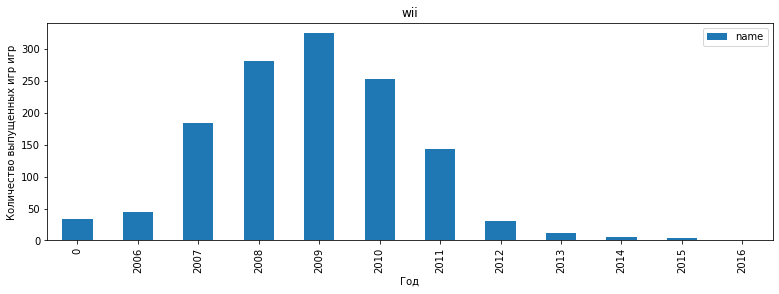

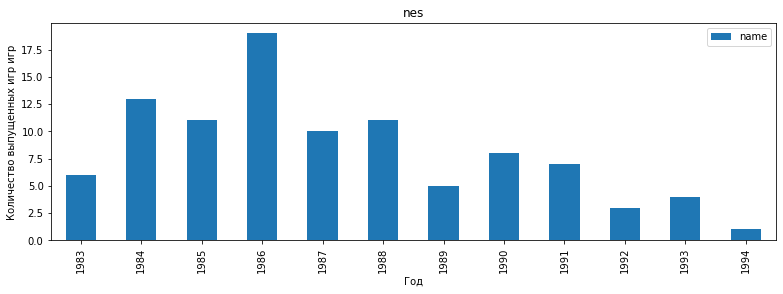

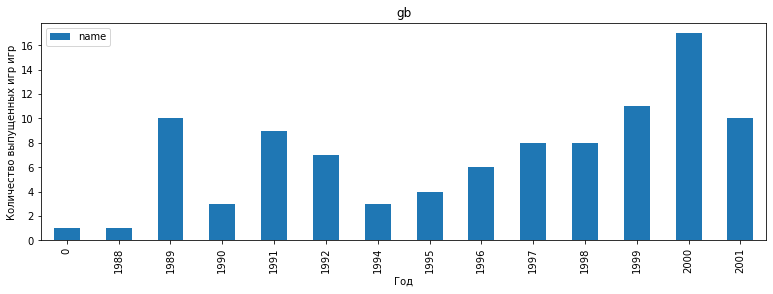

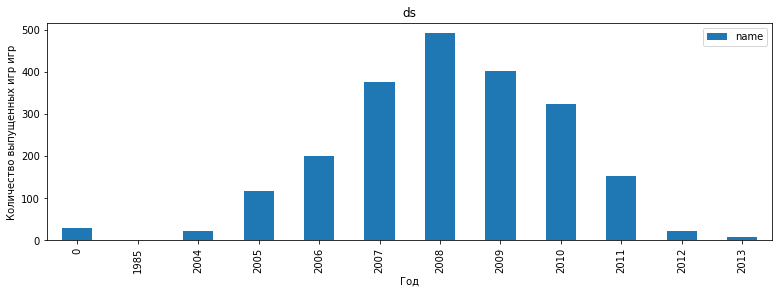

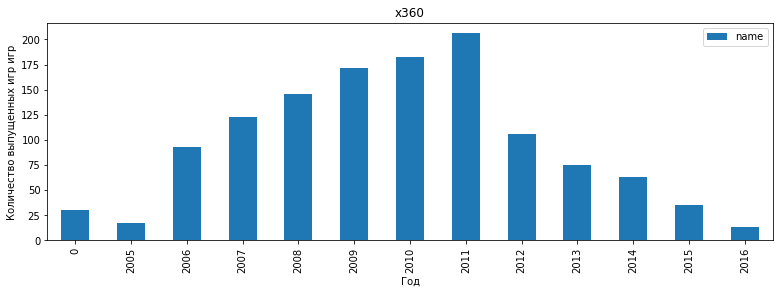

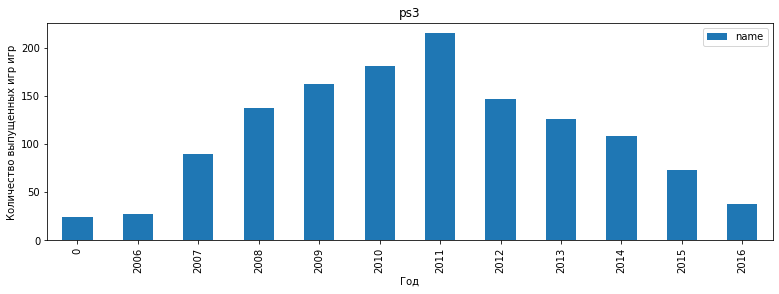

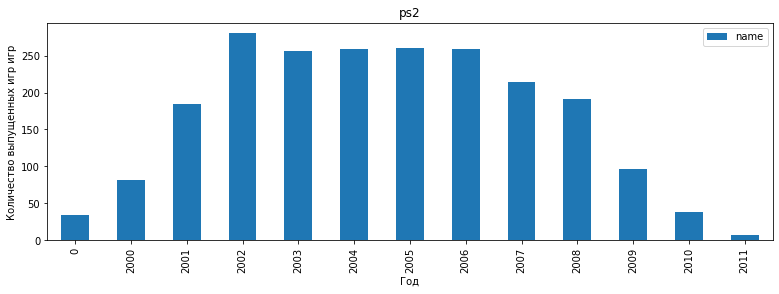

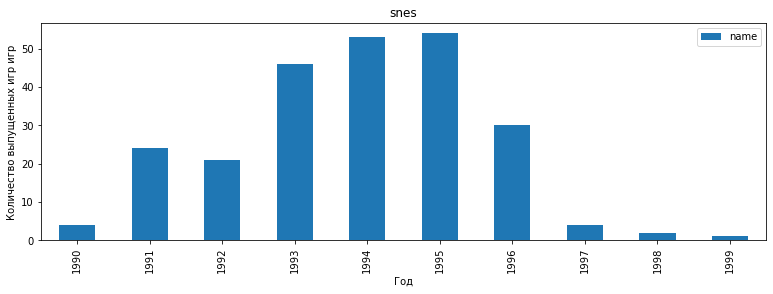

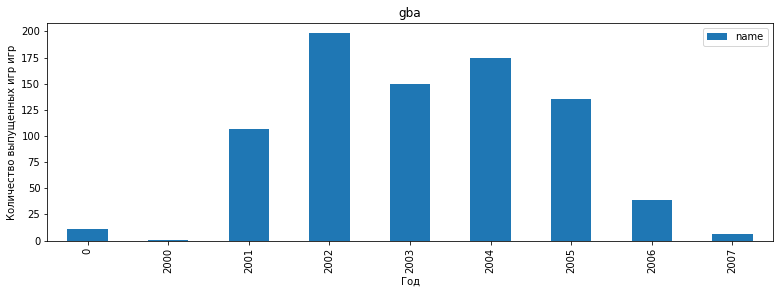

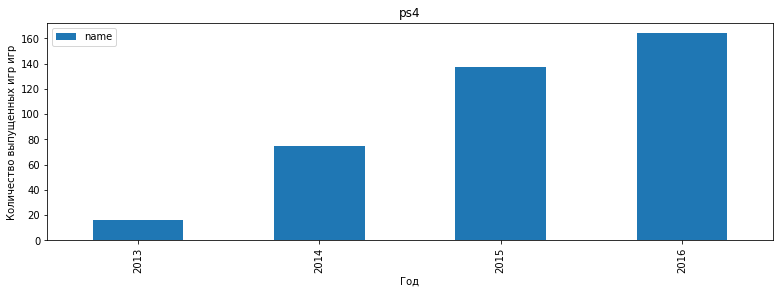

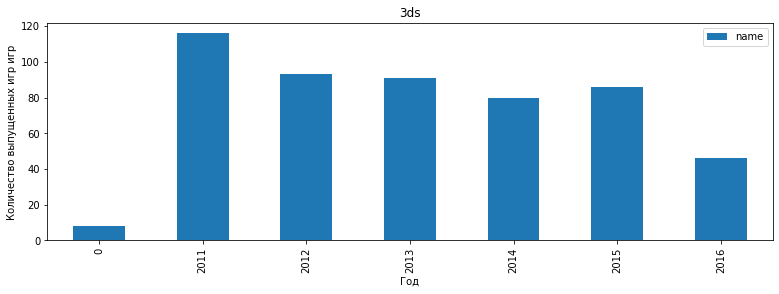

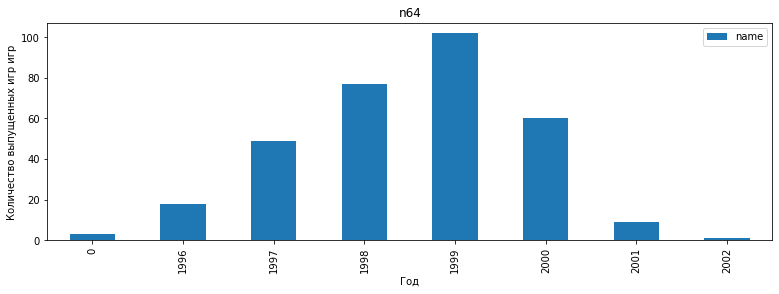

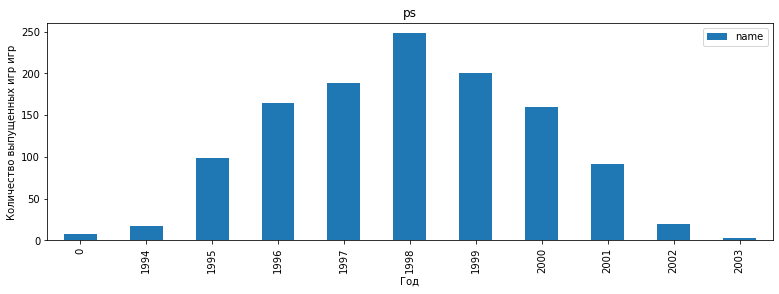

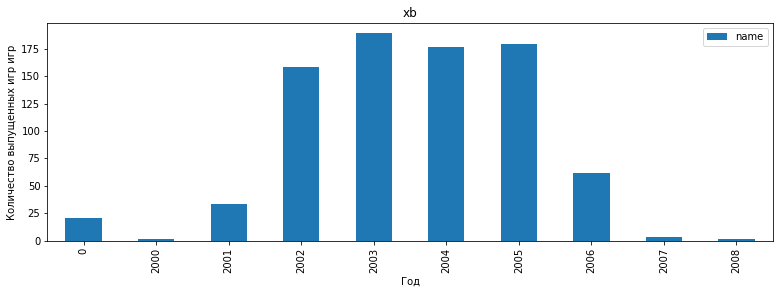

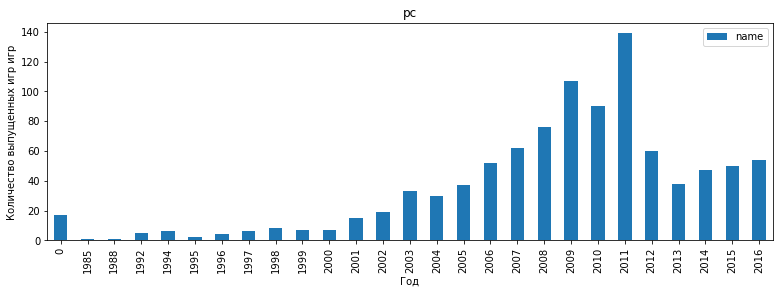

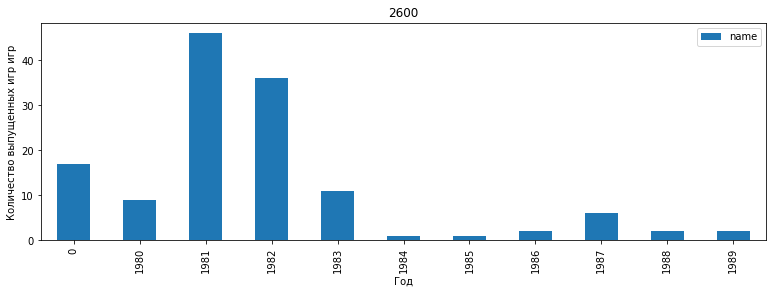

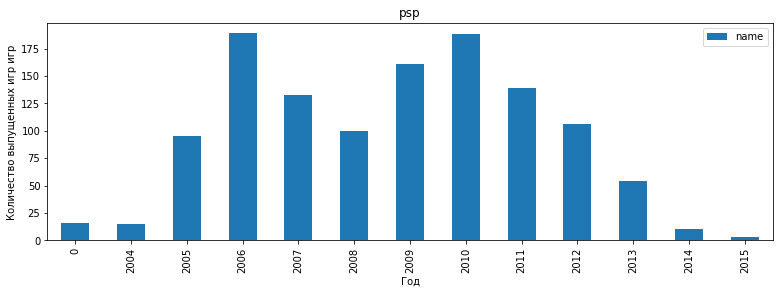

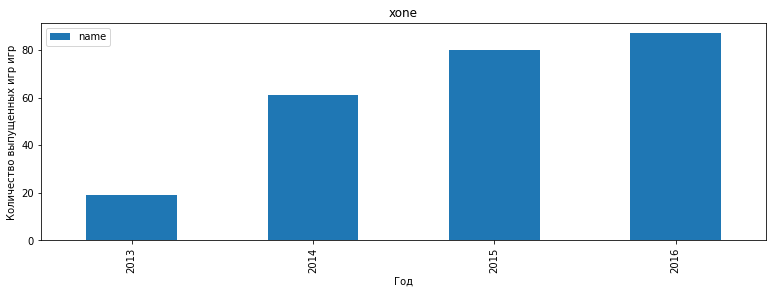

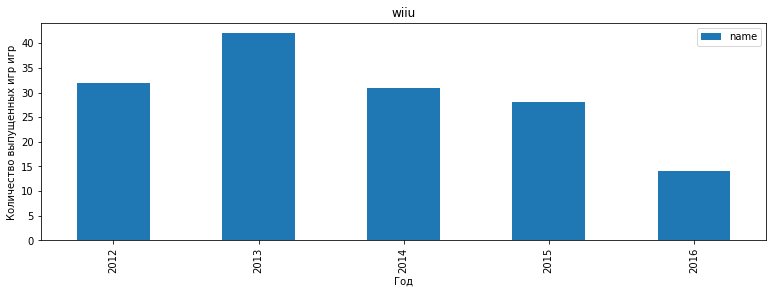

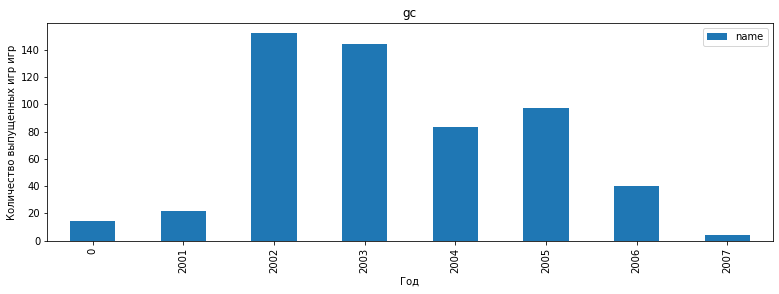

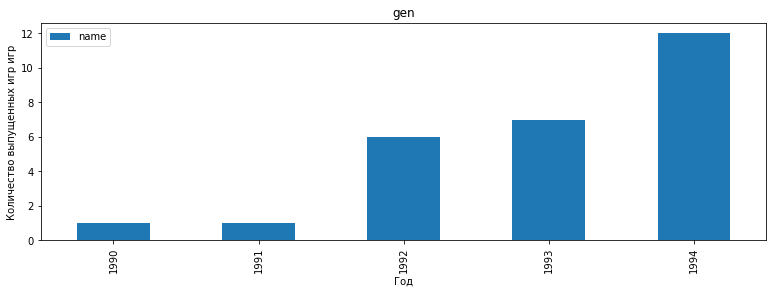

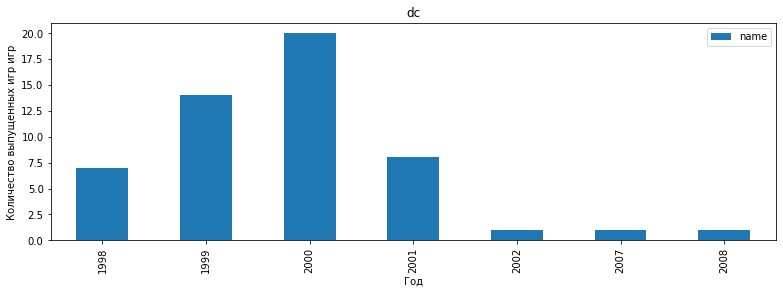

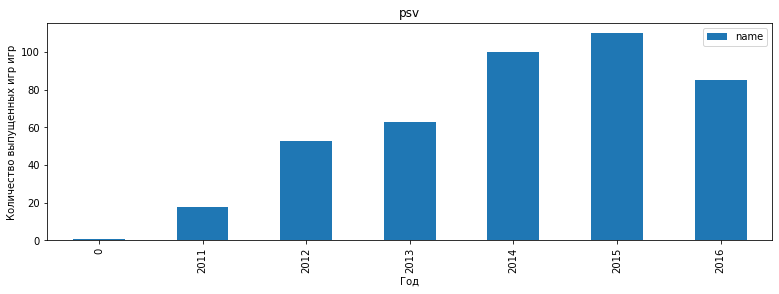

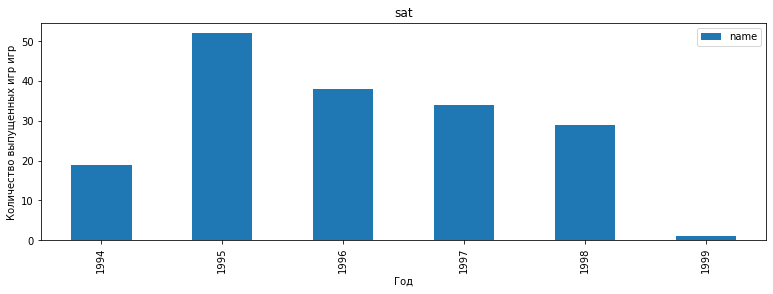

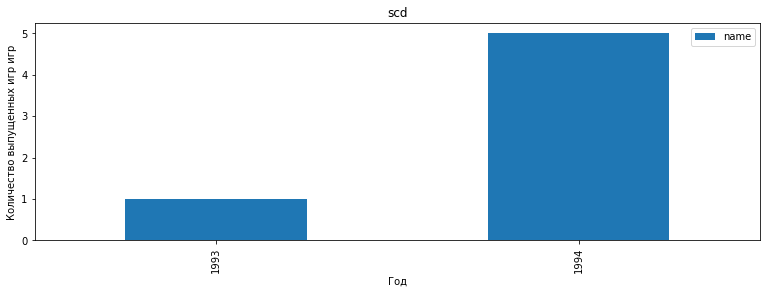

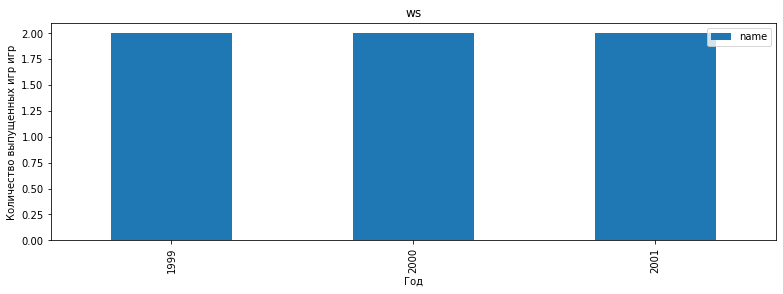

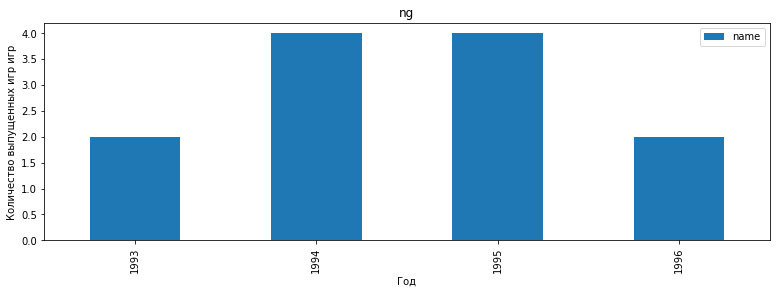

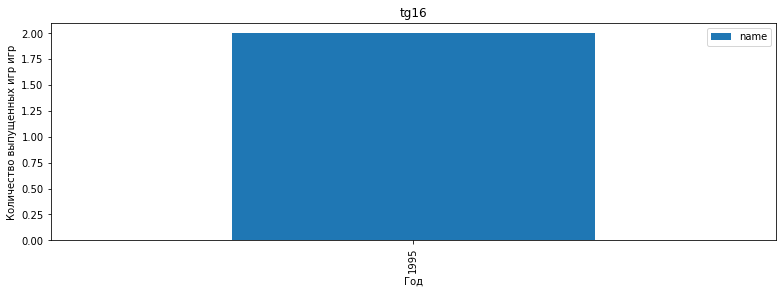

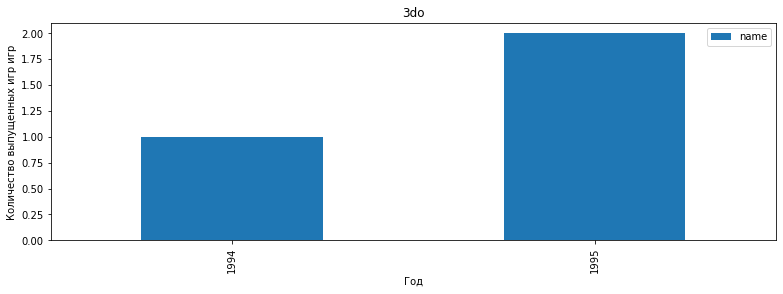

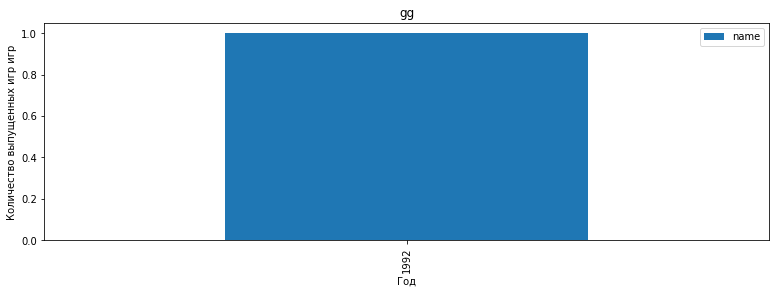

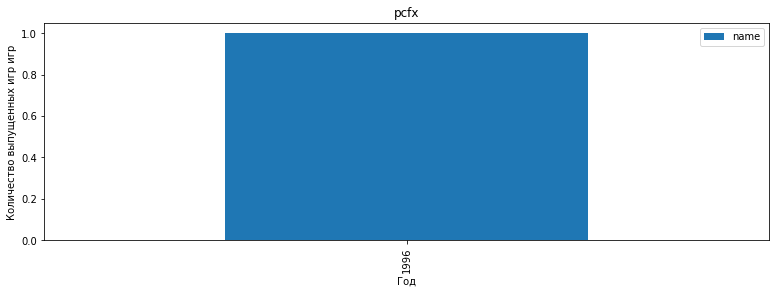

In [14]:
#Построим распределения платформ по годам
platforms=df['platform'].unique()
for platform in platforms:
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='name', aggfunc='count').plot(
        kind='bar', figsize=(13,4))
    plt.title(platform)
    plt.xlabel('Год')
    plt.ylabel('Количество выпущенных игр игр')

После анализа распределений видно, что замена пропусков в графе с годами выпуска одной и той же игры годом выпуска этой же игры на другой платформе не лучший вариант, т.к. вносится много искажений данный.
Удалить эти данные не целесообразно , т.к. они могут быть полезны для анализа максимальных продаж.
На пропуски поставлю заглушку, а ког закомичу. Также видно, что у платформы ds есть выброс.

In [15]:
df1 = df.loc[df['platform']=='ds']
df1 = df1.loc[df1['year_of_release']==1985]

In [16]:
df1

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15957,strongest tokyo university shogi ds,ds,1985,action,0.0,0.0,0.02,0.0,NaN,NaN,NaN


Интернет говорит, что это переиздание игры strongest tokyo university shogi с платформы nes на ds в 2005 году. Исправим это.

In [17]:
df.loc[15957, 'year_of_release'] = 2005


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16710 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16710 non-null  object 
 2   year_of_release  16710 non-null  int64  
 3   genre            16709 non-null  object 
 4   na_sales         16710 non-null  float64
 5   eu_sales         16710 non-null  float64
 6   jp_sales         16710 non-null  float64
 7   other_sales      16710 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       10010 non-null  object 
 10  rating           9945 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 2.0+ MB


In [19]:
df['user_score'].unique()
#есть не понятное значение 'tbd', заменим его на нан

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [20]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [21]:
df['user_score'] = df['user_score'].astype(float)

In [22]:
df['name'].unique()

array(['wii sports', 'super mario bros.', 'mario kart wii', ...,
       'woody woodpecker in crazy castle 5', 'lma manager 2007',
       'haitaka no psychedelica'], dtype=object)

In [23]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16710 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16710 non-null  object 
 2   year_of_release  16710 non-null  int64  
 3   genre            16709 non-null  object 
 4   na_sales         16710 non-null  float64
 5   eu_sales         16710 non-null  float64
 6   jp_sales         16710 non-null  float64
 7   other_sales      16710 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       7586 non-null   float64
 10  rating           9945 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 2.0+ MB


In [25]:
#вроде все ок


Пропусков в Name и Genre очень мало, просто удалим эти значения

In [26]:
df = df.dropna(subset=['name', 'genre'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16709 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16709 non-null  object 
 1   platform         16709 non-null  object 
 2   year_of_release  16709 non-null  int64  
 3   genre            16709 non-null  object 
 4   na_sales         16709 non-null  float64
 5   eu_sales         16709 non-null  float64
 6   jp_sales         16709 non-null  float64
 7   other_sales      16709 non-null  float64
 8   critic_score     8133 non-null   float64
 9   user_score       7586 non-null   float64
 10  rating           9945 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [28]:
df['year_of_release'].unique()
#есть нули, будем разбираться

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000,    0, 1995,
       1991, 1981, 1987, 1980, 1983])

In [29]:
#df = df.loc[df['year_of_release']==0]

In [30]:
#df.info()
#всего 146 значений, это 0,87% от общего удалим их ихз общего df

In [31]:
#Убирем их из общего df
df = df.loc[df['year_of_release']>0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16441 non-null  object 
 1   platform         16441 non-null  object 
 2   year_of_release  16441 non-null  int64  
 3   genre            16441 non-null  object 
 4   na_sales         16441 non-null  float64
 5   eu_sales         16441 non-null  float64
 6   jp_sales         16441 non-null  float64
 7   other_sales      16441 non-null  float64
 8   critic_score     7980 non-null   float64
 9   user_score       7460 non-null   float64
 10  rating           9765 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [32]:
df['genre'].unique()

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy'], dtype=object)

In [33]:
df['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

In [34]:
df['name'].unique()

array(['wii sports', 'super mario bros.', 'mario kart wii', ...,
       'woody woodpecker in crazy castle 5', 'lma manager 2007',
       'haitaka no psychedelica'], dtype=object)

In [35]:
#С critic_score и user_score все сложнее. Значений много, удалять не хорошо, поставлю заглушку.

In [36]:
df['critic_score']=df['critic_score'].fillna(-1)
df['user_score']=df['user_score'].fillna(-1)

Пропуски в поле rating заменить средним нельзя, и удалить тоже пока оставлю как есть или заменю на O_o. Это могут быть игры с пока не присвоенным рейтингом

In [37]:
df['rating']=df['rating'].fillna('O_o')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16441 non-null  object 
 1   platform         16441 non-null  object 
 2   year_of_release  16441 non-null  int64  
 3   genre            16441 non-null  object 
 4   na_sales         16441 non-null  float64
 5   eu_sales         16441 non-null  float64
 6   jp_sales         16441 non-null  float64
 7   other_sales      16441 non-null  float64
 8   critic_score     16441 non-null  float64
 9   user_score       16441 non-null  float64
 10  rating           16441 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Выводы:
Нулевых значений не так много, в большинстве случаев их можно удалить. 
Пропуски в рейтингах удалять нельзя.
Причины появления пропусков:

1. Ошибки при заполнении или выгрузке таблицы.

2. Реально отсутствующие значения отдельных параметров. Например рейтинг, игры могут быть выпущены на той или иной платформе, но не иметь рейтинга, из-за того, что на момент выгрузки данных не прошли оценку. С рейтингом ESRB всё еще интересней, т.к. он только для США и канады, то в ЕС и Японии он не обязателен, и игры продаваемые локально в этих регионах могут его не иметь т.к. он не обязателен.

3. Перевыпуск старых игр на новой платформе, как их считать не понятно, по дате ремейка, или по дате выпуска изначальной игры?

In [39]:
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16441 non-null  object 
 1   platform         16441 non-null  object 
 2   year_of_release  16441 non-null  int64  
 3   genre            16441 non-null  object 
 4   na_sales         16441 non-null  float64
 5   eu_sales         16441 non-null  float64
 6   jp_sales         16441 non-null  float64
 7   other_sales      16441 non-null  float64
 8   critic_score     16441 non-null  float64
 9   user_score       16441 non-null  float64
 10  rating           16441 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' beyblade burst' ' fire emblem fates' " frozen: olaf's quest" ...
 'zwei!!' 'zyuden sentai kyoryuger: game de gaburincho!!'
 '¡shin chan flipa en colores!']
name  : кол-во 0 0 , процент 0 0.0 %

# Исследовательский анализ данных

 # Общие продажи игр по годам

In [40]:
#посчитаем суммарные продажи
df['sales']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']

In [41]:
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,-1.0,-1.0,O_o,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,-1.0,-1.0,O_o,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,samurai warriors: sanada maru,ps3,2016,action,0.00,0.00,0.01,0.00,-1.0,-1.0,O_o,0.01
16711,lma manager 2007,x360,2006,sports,0.00,0.01,0.00,0.00,-1.0,-1.0,O_o,0.01
16712,haitaka no psychedelica,psv,2016,adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,O_o,0.01
16713,spirits & spells,gba,2003,platform,0.01,0.00,0.00,0.00,-1.0,-1.0,O_o,0.01


In [42]:
# Посчитаем количество проданных игр по годам
df1 = df.groupby('year_of_release')['name'].count()
#df1 = df1.sort_values(ascending=False)

In [43]:
df1

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      13
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     651
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

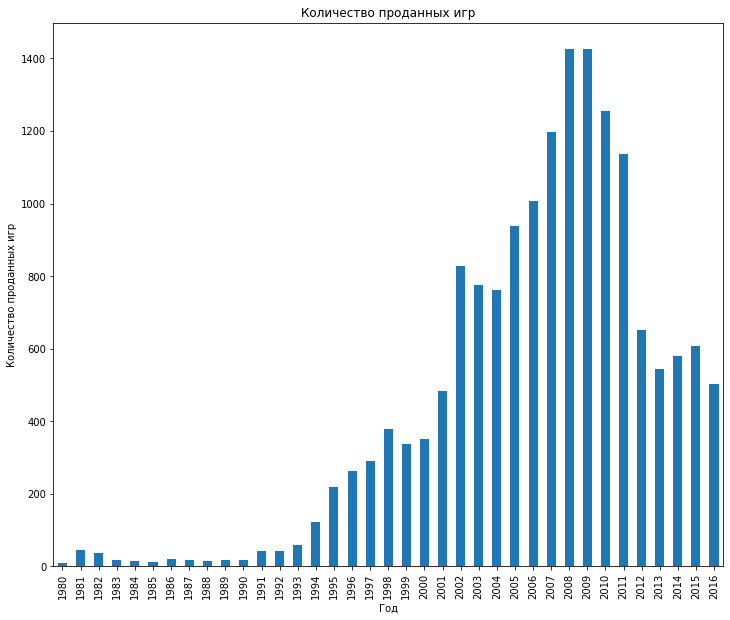

In [44]:
df1.plot(y = 'count', kind='bar', figsize=(12, 10))

plt.title('Количество проданных игр')
plt.xlabel('Год')
plt.ylabel('Количество проданных игр')
plt.show()

Из графика видно что вплоть до 1990 года количество проданных игр мало. Думаю связанно это с малой компьютеризацией. В 90-х года происходит резкий рост количества компьютеров и развитие компьютерной техники, а также повышение вычислительной мощности машин. 
Пик продаж приходится на период 2001 - 2011 годы с пиком в 2008 и 2009 годах.

In [45]:
# Разделим года продаж на периоды
def year_period(year_of_release):
    if year_of_release <= 1989: return '80-e'
    elif year_of_release >= 1990 and year_of_release <= 1999: return '90-e'
    elif year_of_release >= 2000 and year_of_release <= 2009: return '2000-e'
    elif year_of_release > 2009 and year_of_release <= 2017: return '2010-e'
   
df['year_period']=df['year_of_release'].apply(year_period)  
df1=df.groupby('year_period')['name'].count()

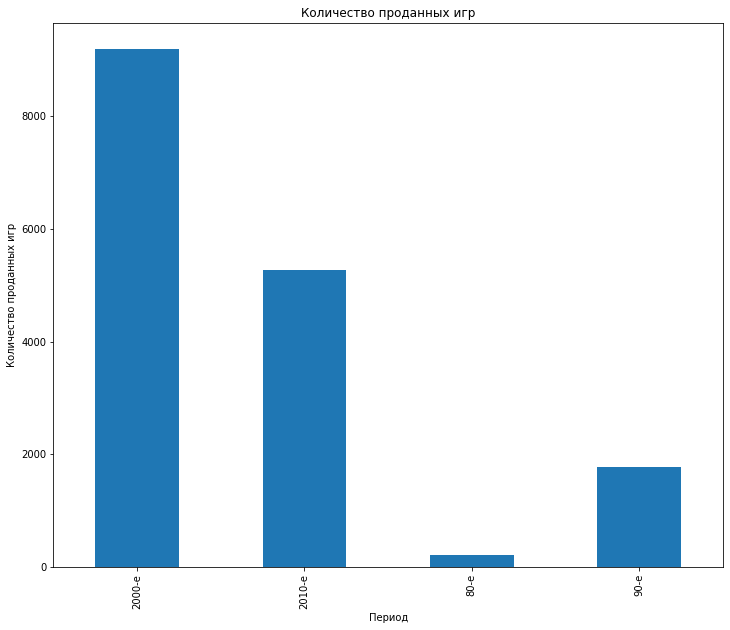

In [46]:
#Построим распределение игр по периодам
df1.plot(y = 'count', kind='bar', figsize=(12, 10))

plt.title('Количество проданных игр')
plt.xlabel('Период')
plt.ylabel('Количество проданных игр')
plt.show()

Предыдущее суждение подтверждается

In [47]:
# Построим зависимость суммарных продаж от года выпуска игры с разбиением на периоды
df1 = df.groupby(['platform', 'year_of_release', 'year_period'])['sales'].sum().reset_index()

In [48]:
df2 = df1.loc[df1['year_period']=='80-e']
df2= df2.loc[df2['sales']>0]
df2 = df2.sort_values('sales', ascending=False)
df2


,platform,year_of_release,year_period,sales
36,gb,1989,80-e,64.97
78,nes,1985,80-e,53.44
77,nes,1984,80-e,50.08
81,nes,1988,80-e,45.01
79,nes,1986,80-e,36.41
1,2600,1981,80-e,35.68
2,2600,1982,80-e,28.88
80,nes,1987,80-e,19.76
0,2600,1980,80-e,11.38
76,nes,1983,80-e,10.96


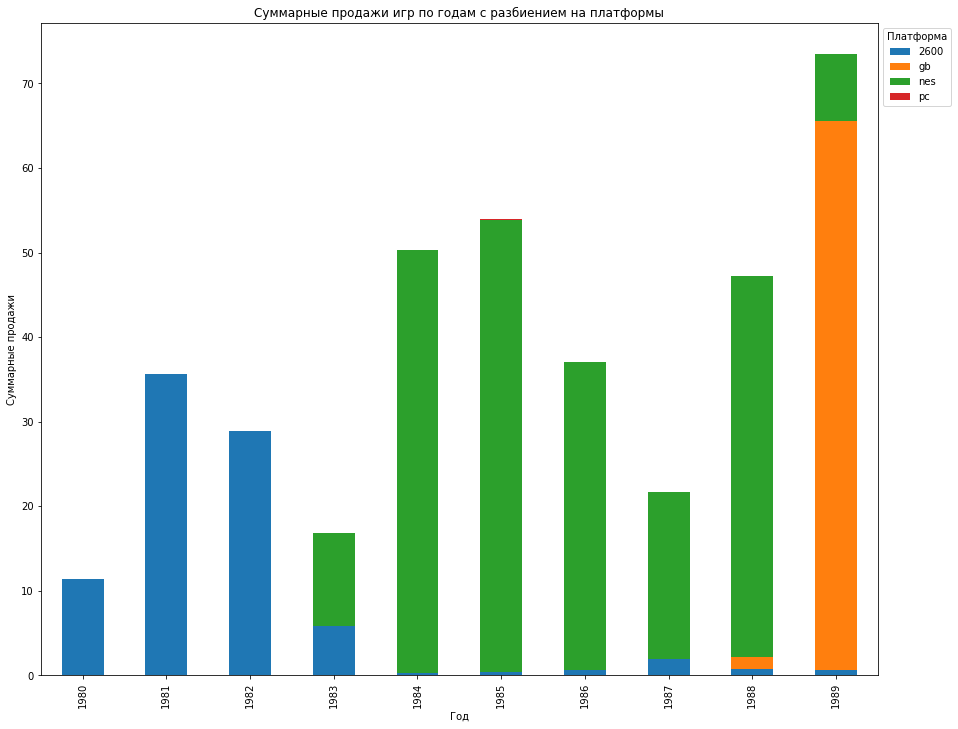

In [49]:
fig, ax = plt.subplots(figsize=(15, 12))
df2 = df2.groupby(['year_of_release', 'platform'])['sales'].sum().unstack()
df2.plot(kind='bar', stacked=True,  ax=ax)

plt.title('Суммарные продажи игр по годам с разбиением на платформы')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1))

plt.show()

В 80-х больше всего продаж было у платформы nes. В 1989 году начинает выстреливать платформа gb.

In [50]:
df2 = df1.loc[df1['year_period']=='90-e']
df2= df2.loc[df2['sales']>0]
df2 = df2.sort_values('sales', ascending=False).reset_index()
df2

,index,platform,year_of_release,year_period,sales
0,123,ps,1998,90-e,169.49
1,124,ps,1999,90-e,144.53
2,122,ps,1997,90-e,136.17
3,121,ps,1996,90-e,94.70
4,72,n64,1999,90-e,57.87
...,...,...,...,...,...
61,179,sat,1999,90-e,0.09
62,11,3do,1995,90-e,0.08
63,68,gg,1992,90-e,0.04
64,118,pcfx,1996,90-e,0.03


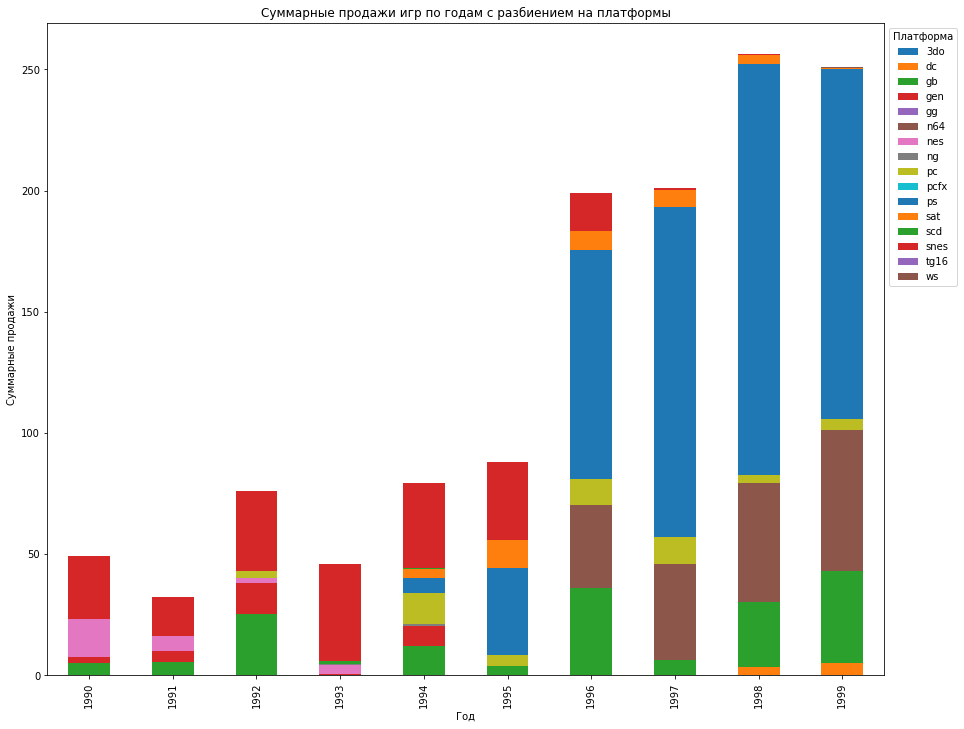

In [51]:
fig, ax = plt.subplots(figsize=(15, 12))
df2 = df2.groupby(['year_of_release', 'platform'])['sales'].sum().unstack()
df2.plot(kind='bar', stacked=True,  ax=ax)

plt.title('Суммарные продажи игр по годам с разбиением на платформы')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1))

plt.show()

В 90-х больше всего продаж было у платформы ps. 

In [52]:
df2 = df1.loc[df1['year_period']=='2000-e']
df2= df2.loc[df2['sales']>0]
df2 = df2.sort_values('sales', ascending=False)
df2

,platform,year_of_release,year_period,sales
133,ps2,2004,2000-e,211.81
196,wii,2009,2000-e,206.97
131,ps2,2002,2000-e,205.38
132,ps2,2003,2000-e,184.31
195,wii,2008,2000-e,171.32
...,...,...,...,...
232,xb,2008,2000-e,0.18
75,n64,2002,2000-e,0.08
48,gba,2000,2000-e,0.07
24,dc,2008,2000-e,0.04


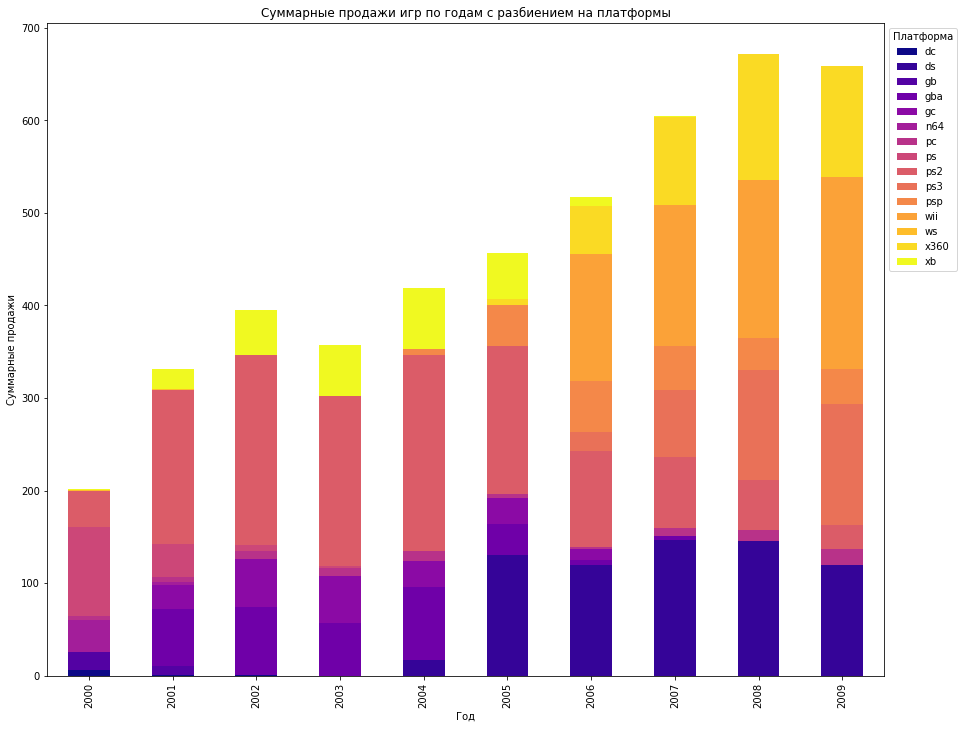

In [53]:

fig, ax = plt.subplots(figsize=(15, 12))
df2 = df2.groupby(['year_of_release', 'platform'])['sales'].sum().unstack()
df2.plot(kind='bar', stacked=True,  colormap='plasma',  ax=ax)

plt.title('Суммарные продажи игр по годам с разбиением на платформы')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1))

plt.show()

В 2000-х все более интересно. С появлением ps2 интерес к старой платформе ps сходит на нет уже в 2001 году. В 2006 году ps2 в продажах теснит платформа wii и xbox360. 

In [54]:
df2 = df1.loc[df1['year_period']=='2010-e']
df2= df2.loc[df2['sales']>0]
df2 = df2.sort_values('sales', ascending=False)
df2

,platform,year_of_release,year_period,sales
217,x360,2010,2010-e,170.03
146,ps3,2011,2010-e,156.78
218,x360,2011,2010-e,143.84
145,ps3,2010,2010-e,142.17
197,wii,2010,2010-e,127.95
...,...,...,...,...
202,wii,2015,2010-e,1.14
140,ps2,2011,2010-e,0.45
166,psp,2014,2010-e,0.24
203,wii,2016,2010-e,0.18


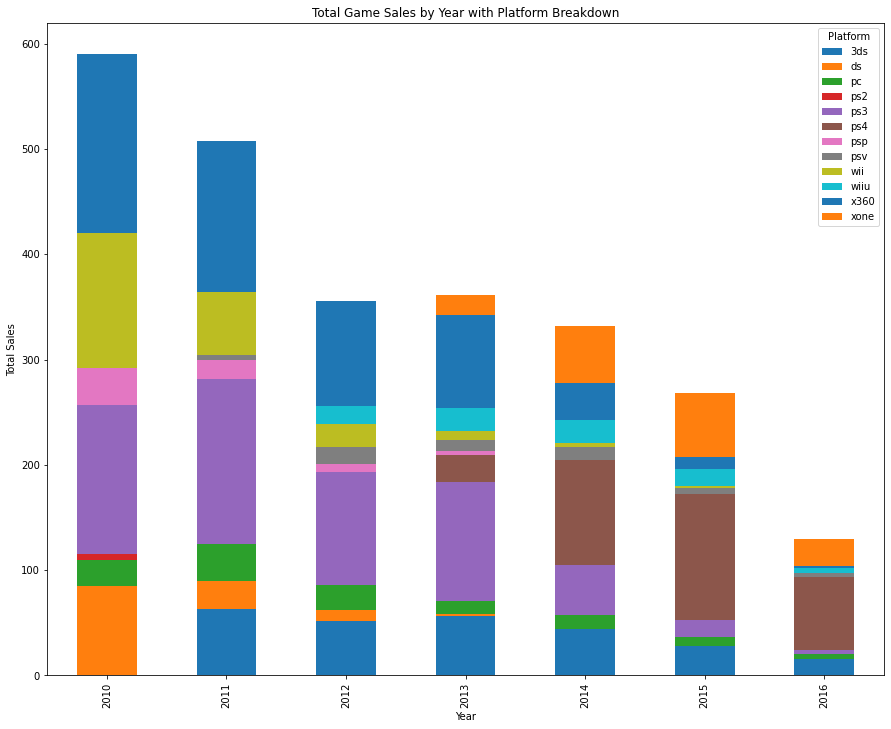

In [55]:

fig, ax = plt.subplots(figsize=(15, 12))
df2 = df2.groupby(['year_of_release', 'platform'])['sales'].sum().unstack()
df2.plot(kind='bar', stacked=True, ax=ax)

plt.title('Total Game Sales by Year with Platform Breakdown')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Platform', bbox_to_anchor=(1, 1))

plt.show()

В 2010-х годах наблюдается спад продаж игр на платформах. И к 2014 году в лидеры выбивается новая платформа ps4.

In [56]:
# Найдем максимальные продажи с группировкой по платформам и году выпуска
df2 = df.groupby(['platform', 'year_of_release'])['sales'].sum().reset_index()
df2= df2.loc[df2['sales']>0]
df2 = df2.sort_values(['sales', 'year_of_release'], ascending=False)
df2.head()

,platform,year_of_release,sales
133,ps2,2004,211.81
196,wii,2009,206.97
131,ps2,2002,205.38
132,ps2,2003,184.31
195,wii,2008,171.32


В топе продаж по годам в разрезе платформ - платформа ps2 и 2004 год, на втором wii и 2009 год, на третьем опять ps2 и 2002 год.

In [57]:
# построим и визуализируем общую таблицу продаж по платформам в разрезе периодов
df2=df1
df2.drop('year_of_release', axis=1, inplace=True)
df2 = df2.groupby(['platform', 'year_period'])['sales'].sum().reset_index()
df2 = df2.sort_values('sales', ascending=False)
df2= df2.loc[df2['sales']>0]
df2

,platform,year_period,sales
26,ps2,2000-e,1227.47
5,ds,2000-e,679.03
38,wii,2000-e,668.21
29,ps3,2010-e,587.73
25,ps,90-e,586.88
44,x360,2010-e,550.41
43,x360,2000-e,409.58
28,ps3,2000-e,343.60
30,ps4,2010-e,314.14
10,gba,2000-e,312.88


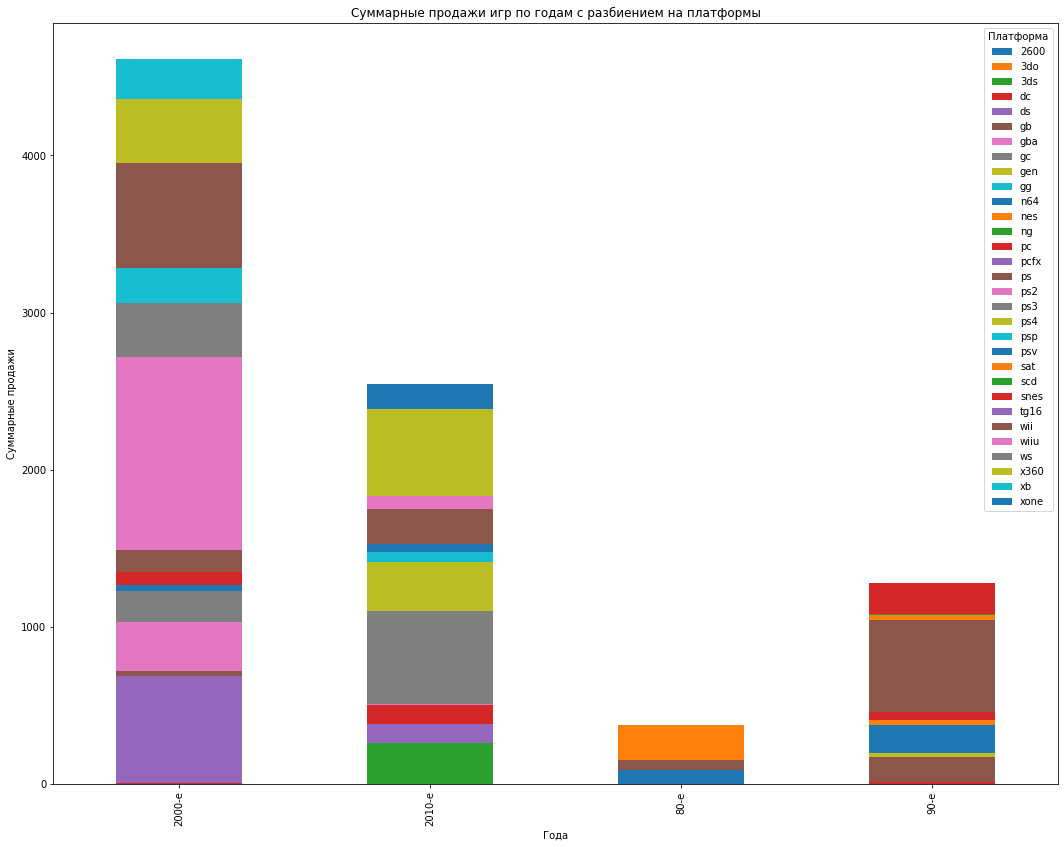

In [58]:
fig, ax = plt.subplots(figsize=(18, 14))

df2 = df2.groupby(['year_period', 'platform'])['sales'].sum().unstack()
df2.plot(kind='bar', stacked=True, ax=ax)

plt.title('Суммарные продажи игр по годам с разбиением на платформы')
plt.xlabel('Года')
plt.ylabel('Суммарные продажи')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1))

plt.show()

Данный график полностью интерпретирует всё выше сказанное.

Выводы:

    -вплоть до 1990 года количество проданных игр мало. вплоть до 1990 года количество проданных игр мало. Думаю связанно это с малой компьютеризацией. В 90-х года происходит резкий рост количества компьютеров и развитие компьютерной техники, а также повышение вычислительной мощности машин. Пик продаж приходится на период 2001 - 2011 годы с пиком в 2008 и 2009 годах.
    
    -В 80-х больше всего продаж было у платформы nes. В 1989 году начинает выстреливать платформа gb.
    
    -В 90-х больше всего продаж было у платформы ps.
    
    -В 2000-х все более интересно. С появлением ps2 интерес к старой платформе ps сходит на нет уже в 2001 году. В 2006 году ps2 в продажах теснит платформа wii и xbox360.
    
    -В 2010-х годах наблюдается спад продаж игр на платформах. И к 2014 году в лидеры выбивается новая платформа ps4.

# Изучение продаж по платформам

In [59]:
df_sales_platform=df.groupby('platform')['sales'].sum().reset_index()
df_sales_platform.rename(columns={'sales': 'count'}, inplace=True)
df_sales_platform=df_sales_platform.sort_values('count', ascending=False)
df_sales_platform.head()

,platform,count
16,ps2,1233.56
28,x360,959.99
17,ps3,931.33
25,wii,891.18
4,ds,802.78


В топе по реализации платформа ps2

In [60]:
platforms=df_sales_platform['platform'].unique()

/opt/conda/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


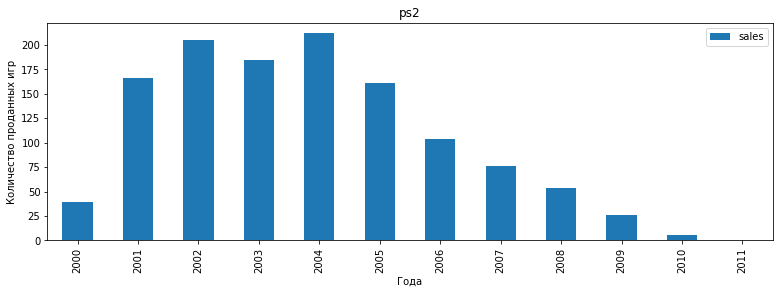

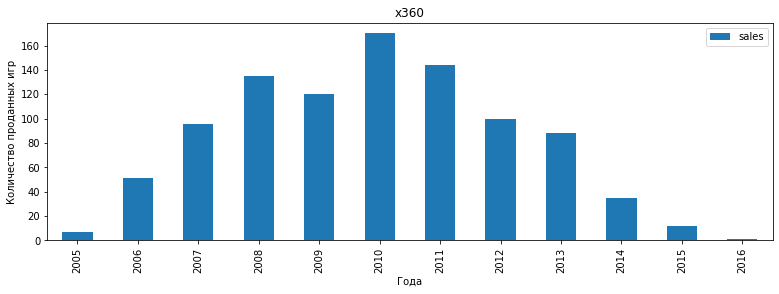

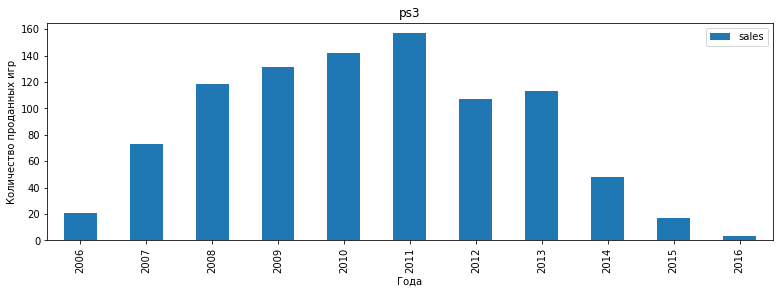

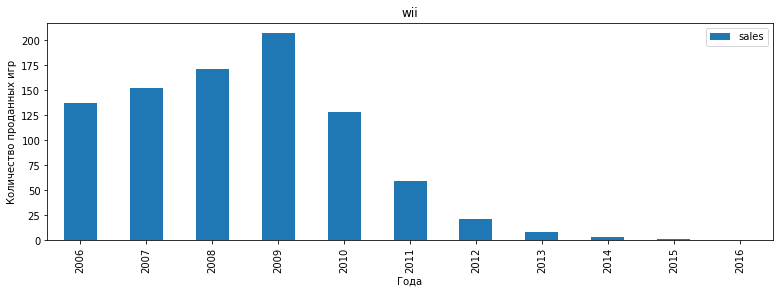

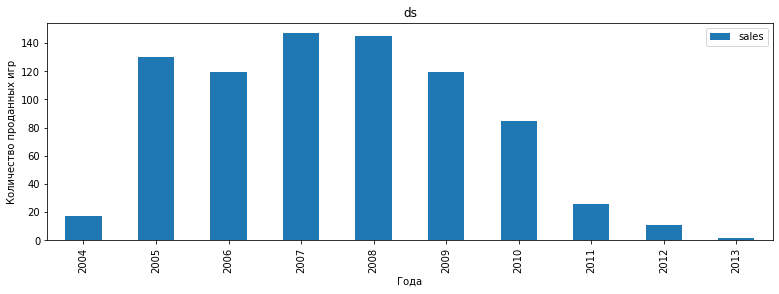

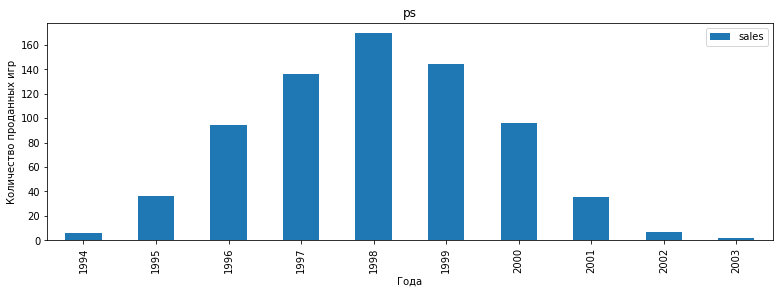

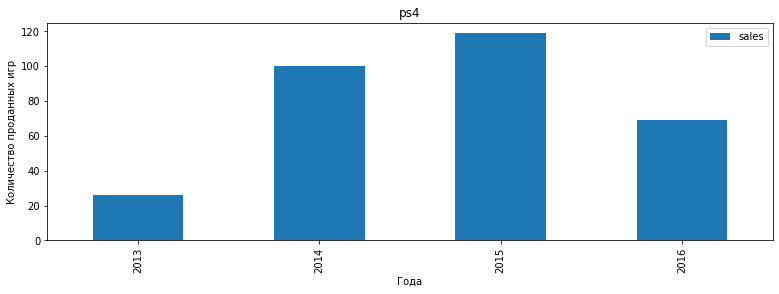

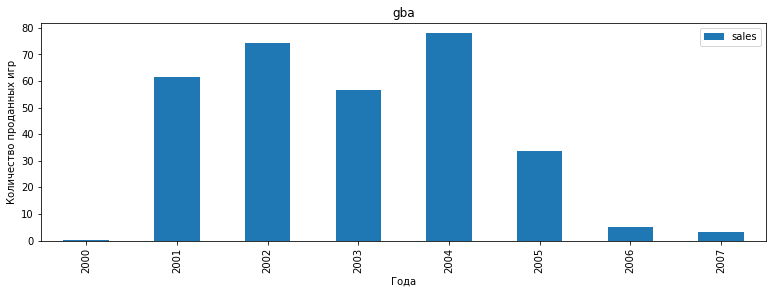

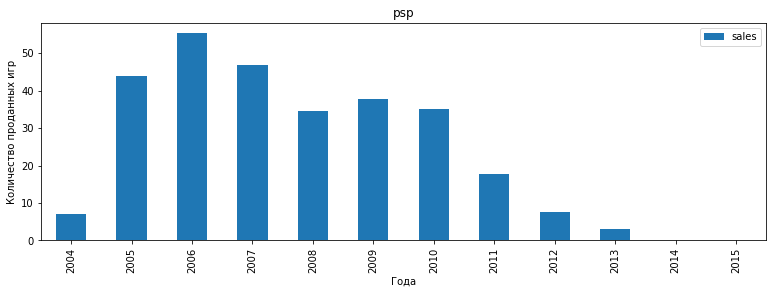

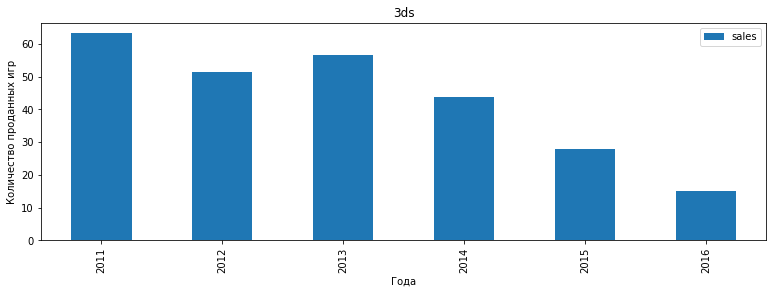

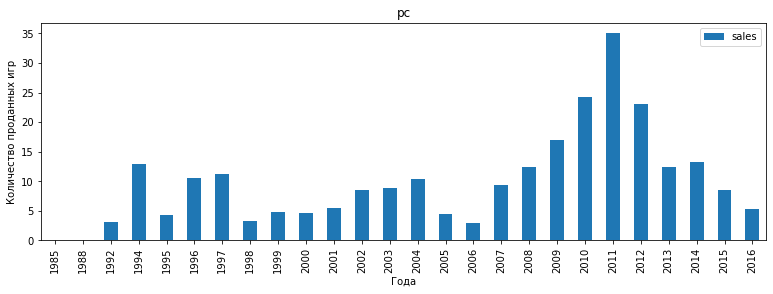

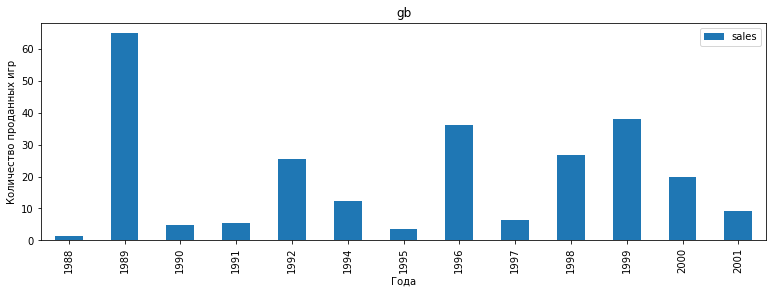

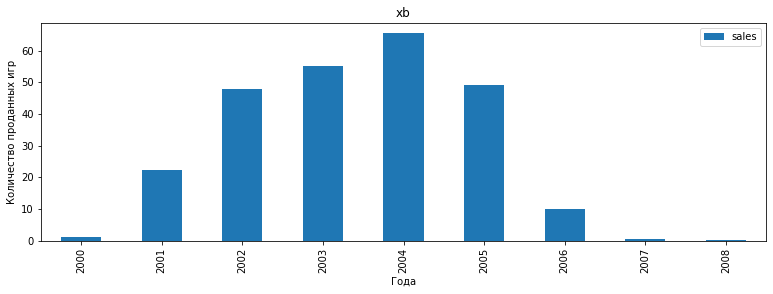

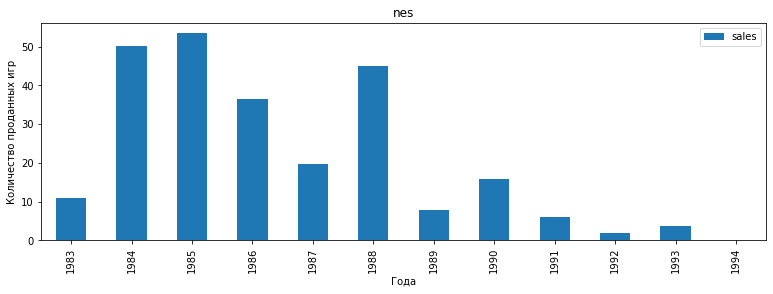

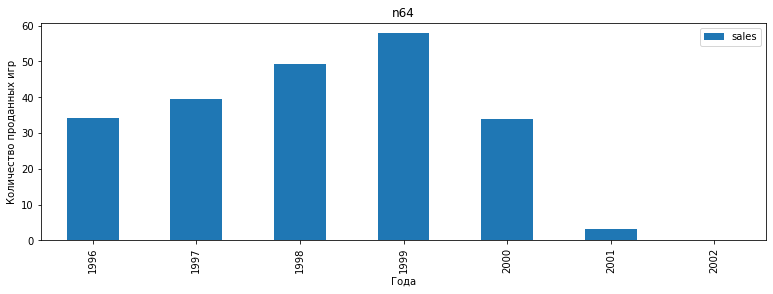

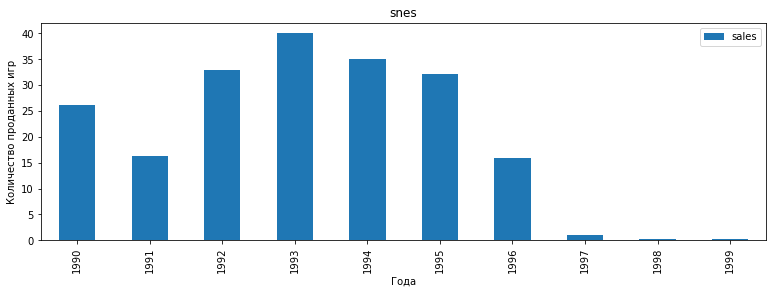

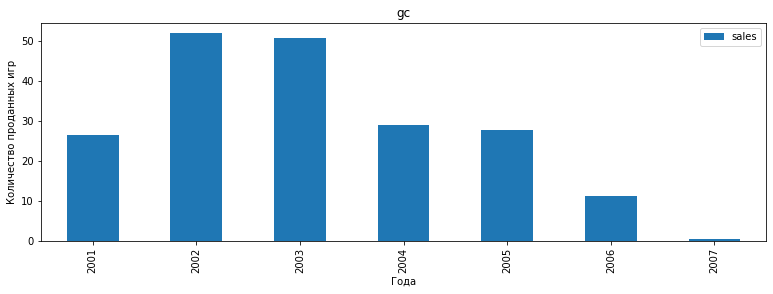

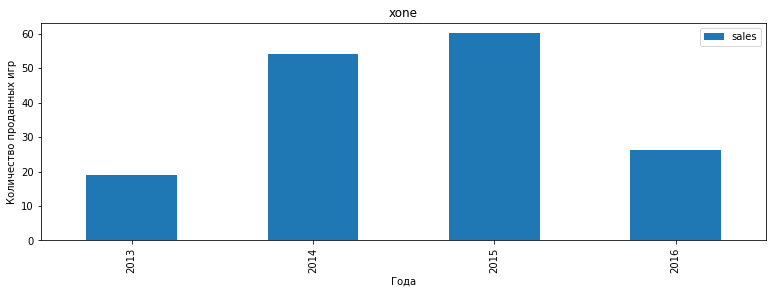

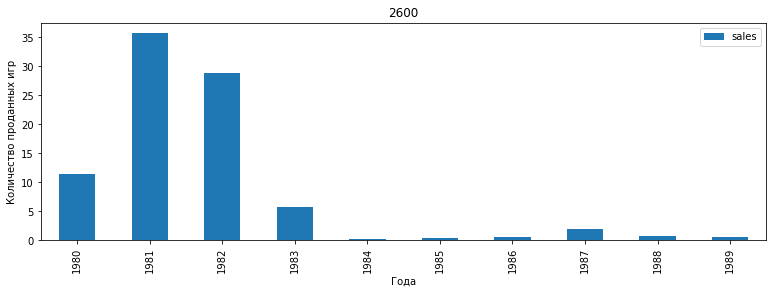

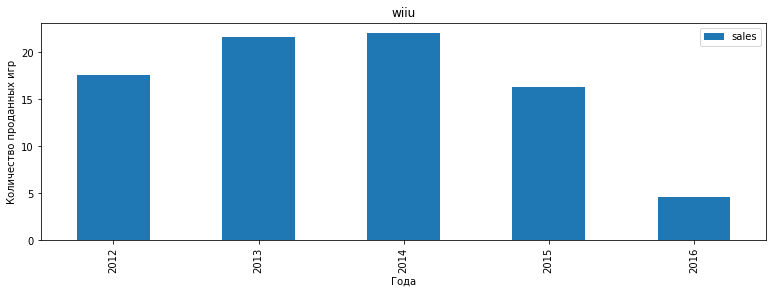

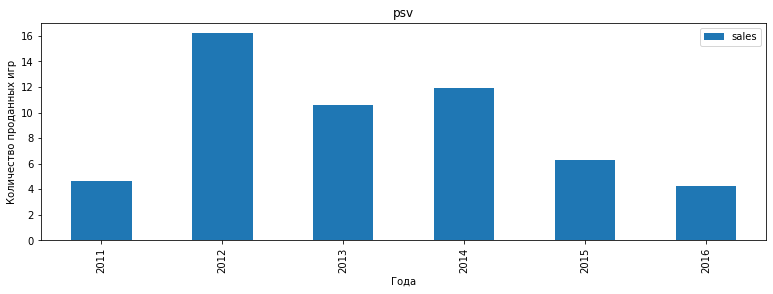

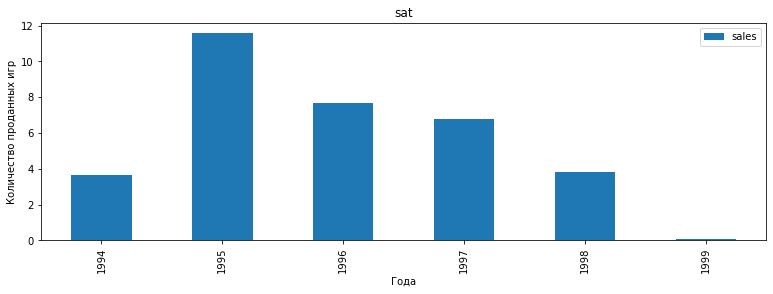

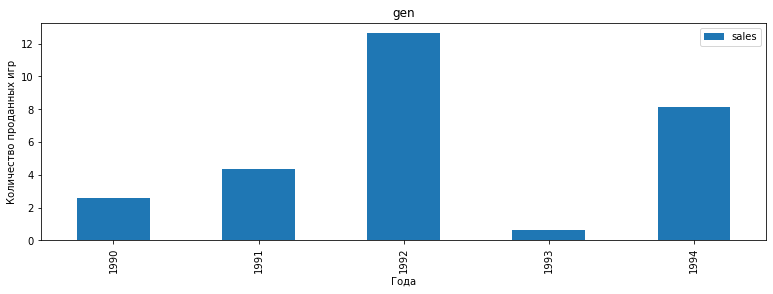

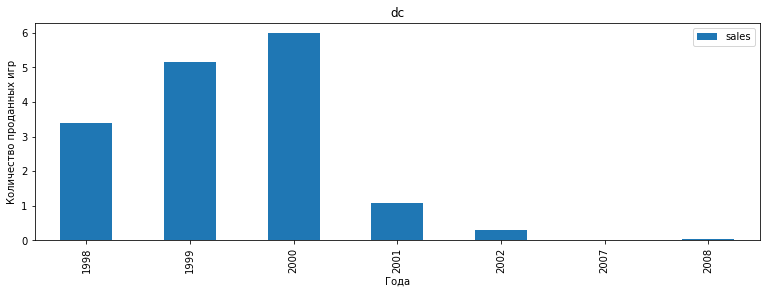

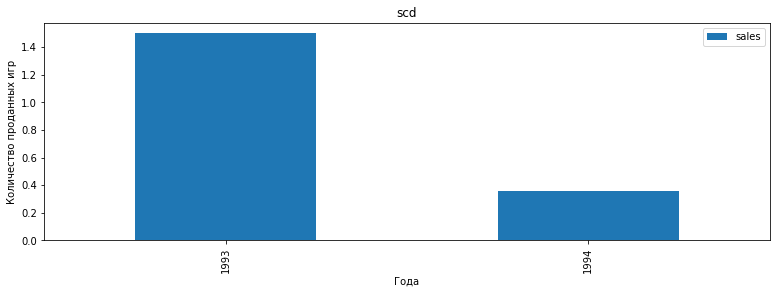

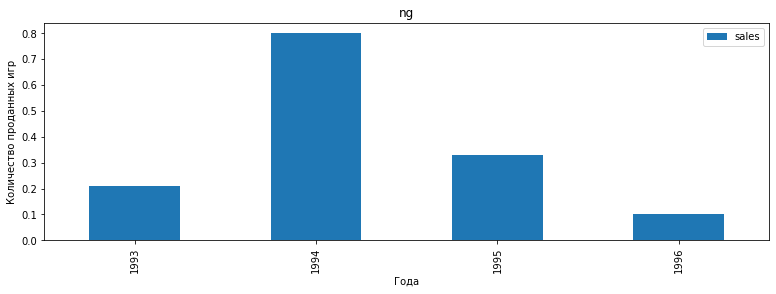

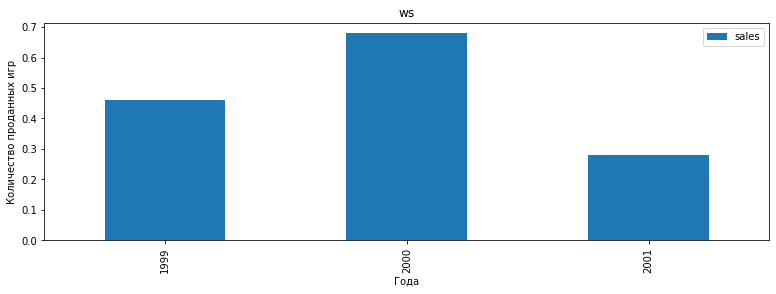

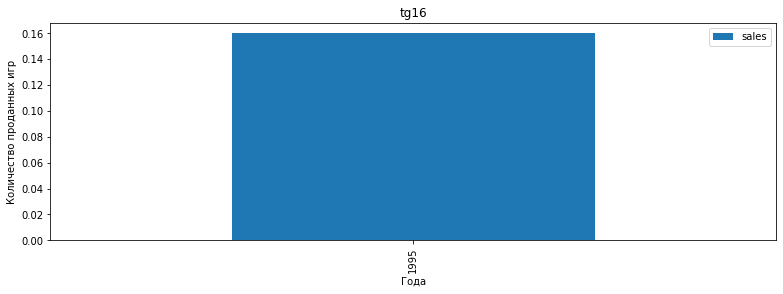

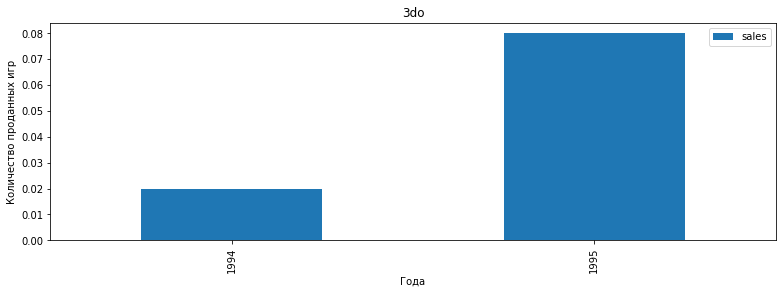

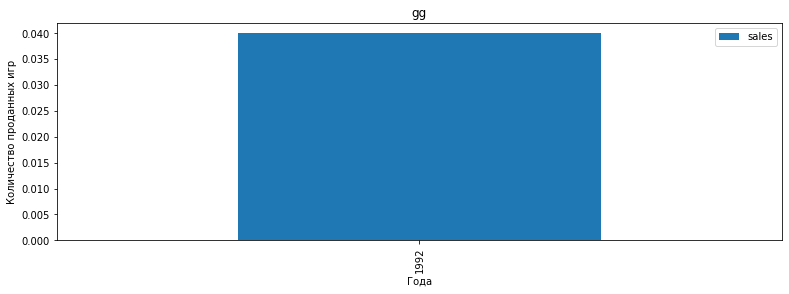

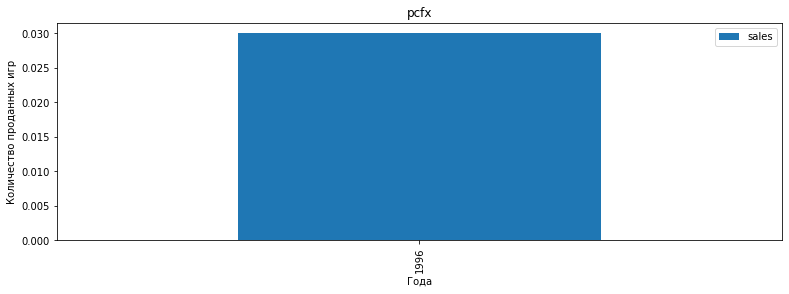

In [61]:
#Построим распределения по годам для каждой платформы.
for platform in platforms:
    df[df['platform'] == platform].pivot_table(index='year_of_release', values='sales', aggfunc='sum').plot(
        kind='bar', figsize=(13,4))
    plt.title(platform)
    plt.xlabel('Года')
    plt.ylabel('Количество проданных игр')

Большинство платформ имеют приближенное к нормальному распределение по годам, за некоторым исключением платформы: gb, pc, snes, scd, tg16, 3do, gg, pcfx.
До 2016 года добрались не многие: PS4, PC, Nintendo 3DS, XBOX One, Nintendo Wii U, PlayStation Vita.  

In [62]:
# срок жизни платформы
temp = df.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

Средний срок жизни платформы составляет 7 лет

In [63]:
#создадим сводную таблицу по продажам платформ
platforms = df.pivot_table(index='platform', values='sales', aggfunc='sum').sort_values(
    by='sales', ascending=False).head(5)
platforms = platforms.reset_index().rename_axis(None, axis=1)
platforms

,platform,sales
0,ps2,1233.56
1,x360,959.99
2,ps3,931.33
3,wii,891.18
4,ds,802.78


In [64]:
current_period = df[df['year_of_release'] > 2013]
current_period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales,year_period
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,O_o,14.63,2010-e
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,2010-e
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,-1.0,-1.0,O_o,11.68,2010-e
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,2010-e
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,-1.0,-1.0,O_o,7.98,2010-e


# Анализ актуального периода

In [65]:
#Топ продаж в актуальном периоде
df_sales_platform_current_period=current_period.groupby('platform')['sales'].sum().reset_index()
df_sales_platform_current_period.rename(columns={'sales': 'count'}, inplace=True)
df_sales_platform_current_period=df_sales_platform_current_period.sort_values('count', ascending=False)
df_sales_platform_current_period.head()

,platform,count
3,ps4,288.15
9,xone,140.36
0,3ds,86.68
2,ps3,68.18
8,x360,48.22


В выбранном периоде лидером по продажам являются:ps4, xone, 3ds

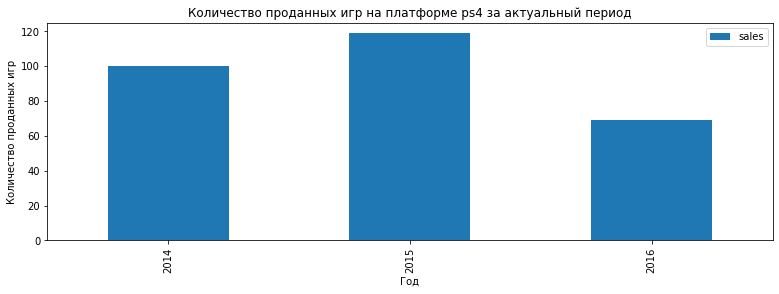

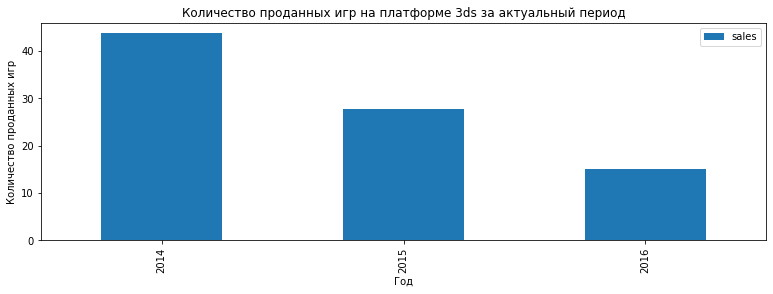

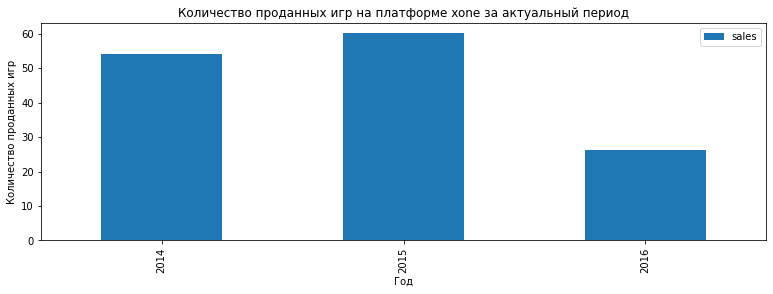

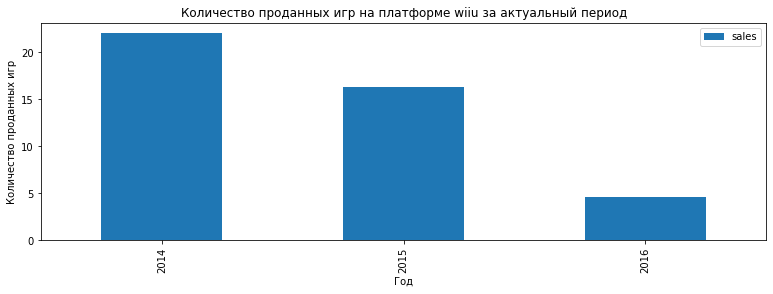

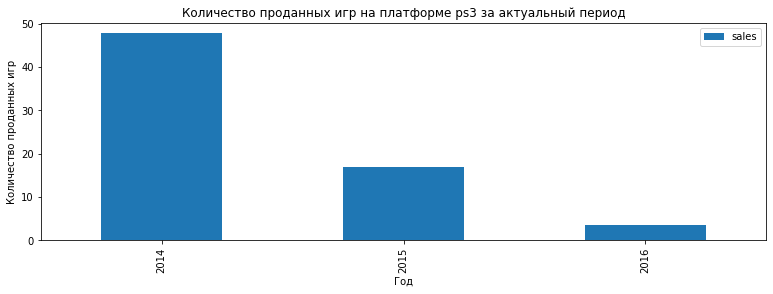

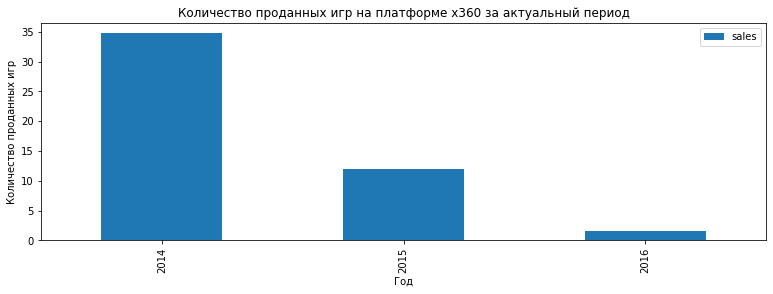

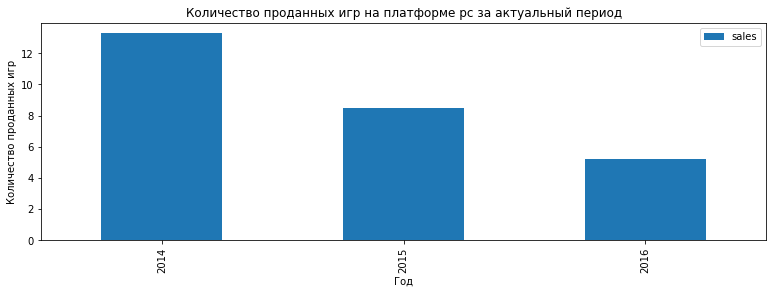

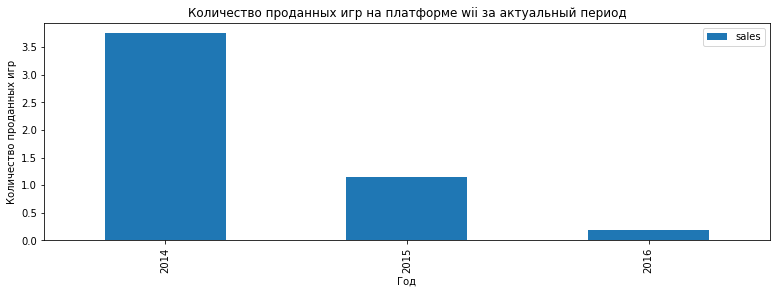

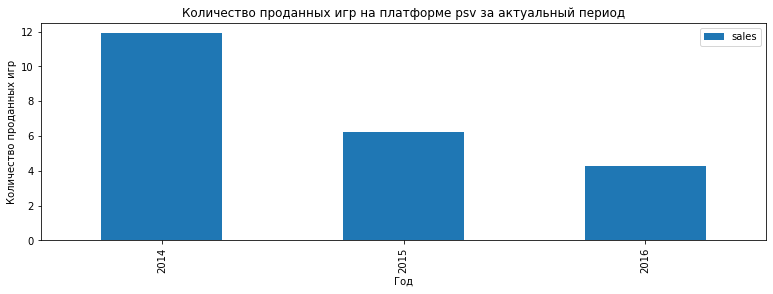

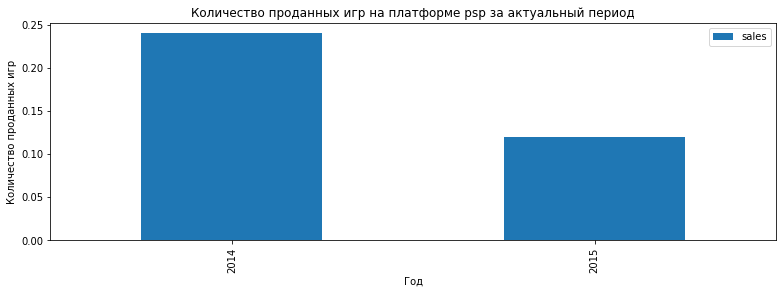

In [66]:
#Построим распределения по годам для каждой платформы на актуальный период.
platforms=current_period['platform'].unique()
for platform in platforms:
    current_period[current_period['platform'] == platform].pivot_table(index='year_of_release', values='sales', aggfunc='sum').plot(
        kind='bar', figsize=(13,4))
    plt.title(f'Количество проданных игр на платформе {platform} за актуальный период')
    plt.xlabel('Год')
    plt.ylabel('Количество проданных игр')

Множество платформ к 2016 году умерли. ps4, xone к 2016 году все еще остается, но пик ее прошел в 2014-2015 годах. Почти также себя ведут и продажи 3ds, wiiu за одним исключением - пик приходится на первую половину 2010-х годов. psv тоже жива к 2016 , но пик ее - 2012-2014 года

# "Ящик с усами" по глобальным продажам игр в разбивке по платформам.

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

Text(0, 0.5, 'Глобальные продажи')

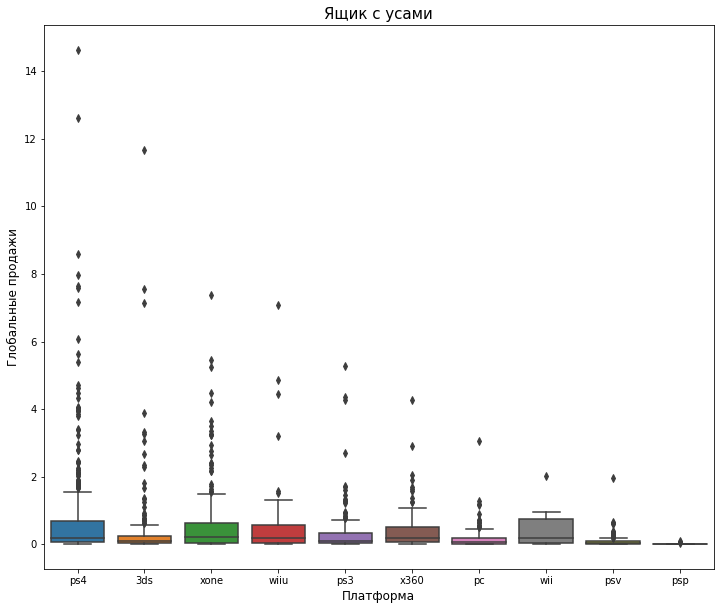

In [67]:
#Отрисуем ящики с усами 
plt.figure(figsize=(12,10))
sns.boxplot(data=current_period, x='platform', y='sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)

(0.0, 1.6)

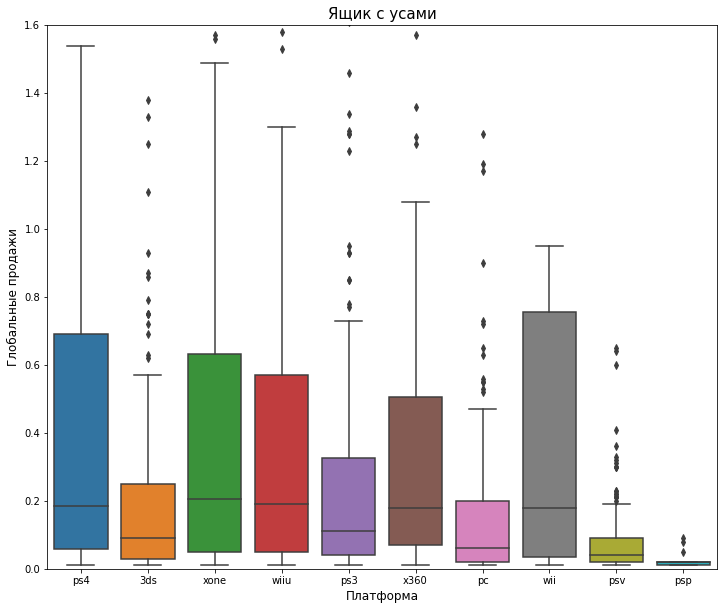

In [68]:
plt.figure(figsize=(12,10))
sns.boxplot(data=current_period, x='platform', y='sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи', fontsize=12)
plt.ylim(0, 1.6)  # ограничим диапазон до 1.6

In [69]:
current_period.groupby('platform')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3ds,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
pc,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
ps3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
ps4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
psp,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
psv,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
wiiu,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
x360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


Выводы:
    Исходя из графиков видно, что медиана протекает у всех по разному.
    топ 3 платформы по продажам за выбранный период - ps4, xone, wiiu
    Персональные компьютеры отошли на второй план, уступив место приставкам.

# Исследование продаж внутри каждой из платформ

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [70]:
# отфильтруем df

df1 = current_period[(current_period['user_score'] > 0)]

In [73]:
#Возьмем wiiu

In [74]:
wiiu = current_period[current_period['platform']=='wiiu']
wiiu['user_score'].corr(wiiu['sales'])

0.2536935934609974

Text(0, 0.5, 'Продажи игр на платформе')

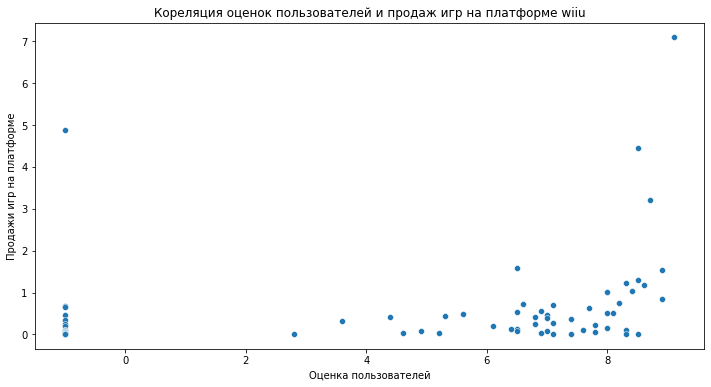

In [75]:
#Построим диаграмму рассеяния
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='sales', data=wiiu)
plt.title('Кореляция оценок пользователей и продаж игр на платформе wiiu')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи игр на платформе')

Для wiiu корреляция между оценками пользователей и продажами слабая

In [76]:
#Корреляция между оценками критиков и продажами 
df1 = current_period[(current_period['critic_score'] > 0)]
wiiu = df1[df1['platform']=='wiiu']
wiiu['critic_score'].corr(wiiu['sales'])

0.370201412480884

Text(0, 0.5, 'Продажи игр на платформе')

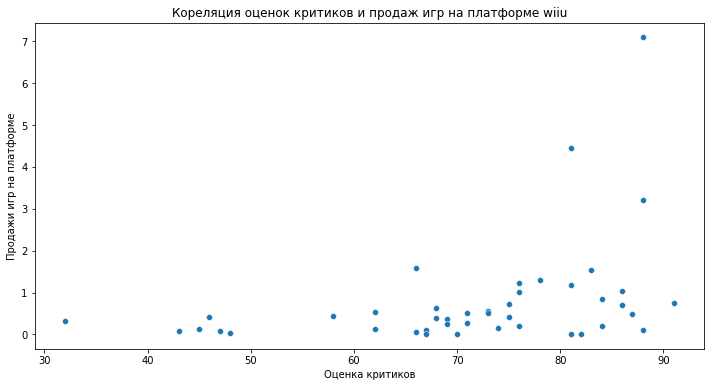

In [77]:
#Построим диаграмму рассеяния по оценкам критиков 
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='sales', data=wiiu)
plt.title('Кореляция оценок критиков и продаж игр на платформе wiiu')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи игр на платформе')

Для wiiu корреляция между оценками критиков и продажами также слабая

Посчитаем корреляцию для других платформ


In [78]:
#Сохраним все платформы в DF
platforms=current_period['platform'].unique()
platforms

array(['ps4', '3ds', 'xone', 'wiiu', 'ps3', 'x360', 'pc', 'wii', 'psv',
       'psp'], dtype=object)

In [79]:
#создадим два отфильтрованных датасета
platform_user=current_period[(current_period['user_score'] > 0)]
platform_critic=current_period[(current_period['critic_score'] > 0)]

In [80]:
platform_critic['platform'].unique()

array(['ps4', 'wiiu', 'xone', '3ds', 'pc', 'x360', 'ps3', 'psv'],
      dtype=object)

In [81]:
platform_user['platform'].unique()

array(['ps4', 'wiiu', 'xone', 'ps3', 'x360', '3ds', 'pc', 'wii', 'psv'],
      dtype=object)

Анализируя два последних списка, видно, что платформа wii встречается только в списке с оценками пользователей. Поэтому дальнейший анализ этой платформы не актуален, psp после фильтрации также пропала.

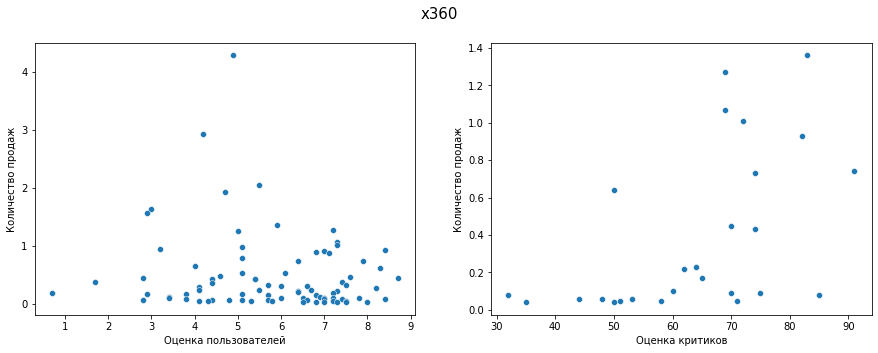

Корреляция между отзывами критиков и игровой платформой  x360 0.5257228356581523
Корреляция между отзывами пользователей и продажами  x360 -0.138444570945665


In [82]:
#Посчитаем и отрисуем корреляцию для платформы 'x360'
platform_user_x360 = platform_user[platform_user['platform']=='x360']
platform_critic_x360 = platform_critic[platform_critic['platform']=='x360']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_x360, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_x360, ax=ax[1])
fig.suptitle('x360', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_x360['user_score'].corr(platform_user_x360['sales'])
critic_correl = platform_critic_x360['critic_score'].corr(platform_critic_x360['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'x360', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'x360', correl_user)

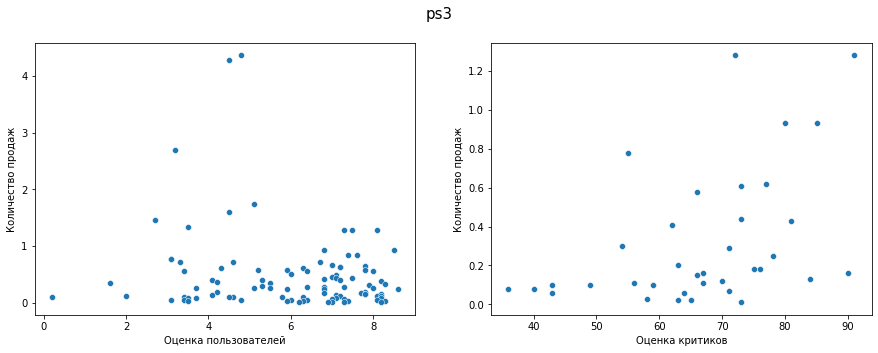

Корреляция между отзывами критиков и игровой платформой  ps3 0.44657460493190704
Корреляция между отзывами пользователей и продажами  ps3 -0.16676141347662118


In [83]:
#Посчитаем и отрисуем корреляцию для платформы 'ps3'
platform_user_ps3 = platform_user[platform_user['platform']=='ps3']
platform_critic_ps3 = platform_critic[platform_critic['platform']=='ps3']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_ps3, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_ps3, ax=ax[1])
fig.suptitle('ps3', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_ps3['user_score'].corr(platform_user_ps3['sales'])
critic_correl = platform_critic_ps3['critic_score'].corr(platform_critic_ps3['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'ps3', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'ps3', correl_user)

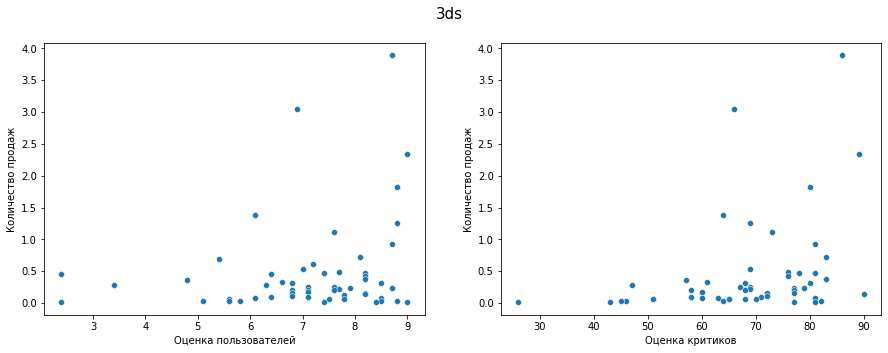

Корреляция между отзывами критиков и игровой платформой  3ds 0.314117492869051
Корреляция между отзывами пользователей и продажами  3ds 0.2151932718527028


In [84]:
#Посчитаем и отрисуем корреляцию для платформы '3ds'
platform_user_3ds = platform_user[platform_user['platform']=='3ds']
platform_critic_3ds = platform_critic[platform_critic['platform']=='3ds']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_3ds, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_3ds, ax=ax[1])
fig.suptitle('3ds', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_3ds['user_score'].corr(platform_user_3ds['sales'])
critic_correl = platform_critic_3ds['critic_score'].corr(platform_critic_3ds['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', '3ds', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', '3ds', correl_user)

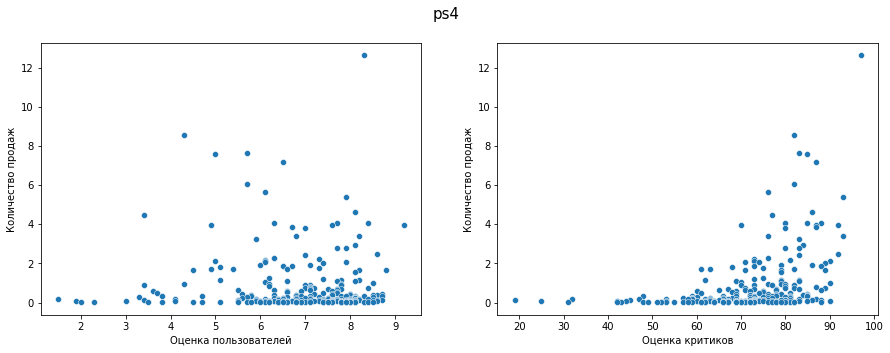

Корреляция между отзывами критиков и игровой платформой  ps4 0.40266141068104083
Корреляция между отзывами пользователей и продажами  ps4 -0.040131589472697356


In [85]:
#Посчитаем и отрисуем корреляцию для платформы 'ps4'
platform_user_ps4 = platform_user[platform_user['platform']=='ps4']
platform_critic_ps4 = platform_critic[platform_critic['platform']=='ps4']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_ps4, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_ps4, ax=ax[1])
fig.suptitle('ps4', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_ps4['user_score'].corr(platform_user_ps4['sales'])
critic_correl = platform_critic_ps4['critic_score'].corr(platform_critic_ps4['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'ps4', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'ps4', correl_user)

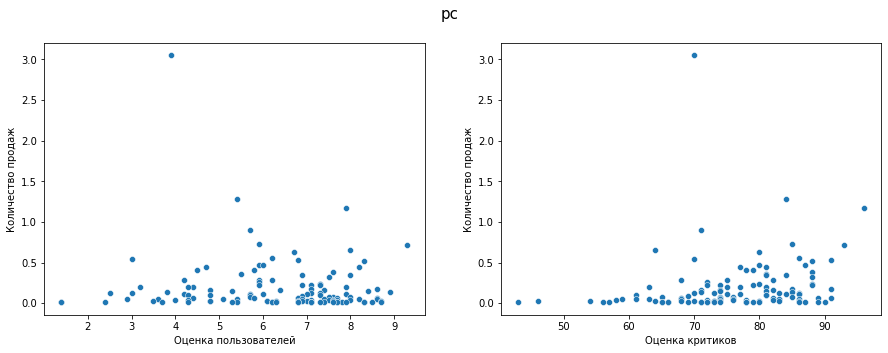

Корреляция между отзывами критиков и игровой платформой  pc 0.17463413769350036
Корреляция между отзывами пользователей и продажами  pc -0.07159665703472451


In [86]:
#Посчитаем и отрисуем корреляцию для платформы 'pc'
platform_user_pc = platform_user[platform_user['platform']=='pc']
platform_critic_pc = platform_critic[platform_critic['platform']=='pc']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_pc, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_pc, ax=ax[1])
fig.suptitle('pc', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_pc['user_score'].corr(platform_user_pc['sales'])
critic_correl = platform_critic_pc['critic_score'].corr(platform_critic_pc['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'pc', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'pc', correl_user)

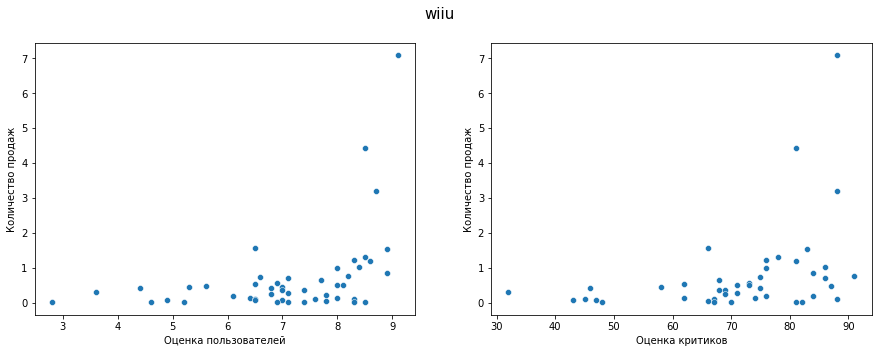

Корреляция между отзывами критиков и игровой платформой  wiiu 0.370201412480884
Корреляция между отзывами пользователей и продажами  wiiu 0.40792645792170773


In [87]:
#Посчитаем и отрисуем корреляцию для платформы 'wiiu'
platform_user_wiiu = platform_user[platform_user['platform']=='wiiu']
platform_critic_wiiu = platform_critic[platform_critic['platform']=='wiiu']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_wiiu, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_wiiu, ax=ax[1])
fig.suptitle('wiiu', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_wiiu['user_score'].corr(platform_user_wiiu['sales'])
critic_correl = platform_critic_wiiu['critic_score'].corr(platform_critic_wiiu['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'wiiu', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'wiiu', correl_user)

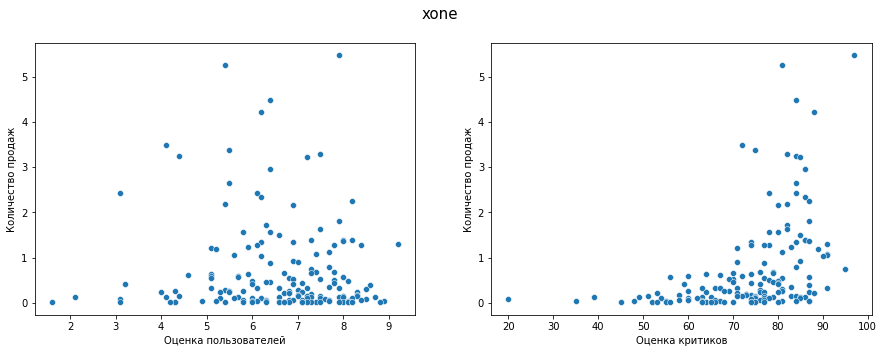

Корреляция между отзывами критиков и игровой платформой  xone 0.42867694370333226
Корреляция между отзывами пользователей и продажами  xone -0.0703839280647581


In [88]:
#Посчитаем и отрисуем корреляцию для платформы 'xone'
platform_user_xone = platform_user[platform_user['platform']=='xone']
platform_critic_xone = platform_critic[platform_critic['platform']=='xone']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_xone, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_xone, ax=ax[1])
fig.suptitle('xone', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_xone['user_score'].corr(platform_user_xone['sales'])
critic_correl = platform_critic_xone['critic_score'].corr(platform_critic_xone['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'xone', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'xone', correl_user)

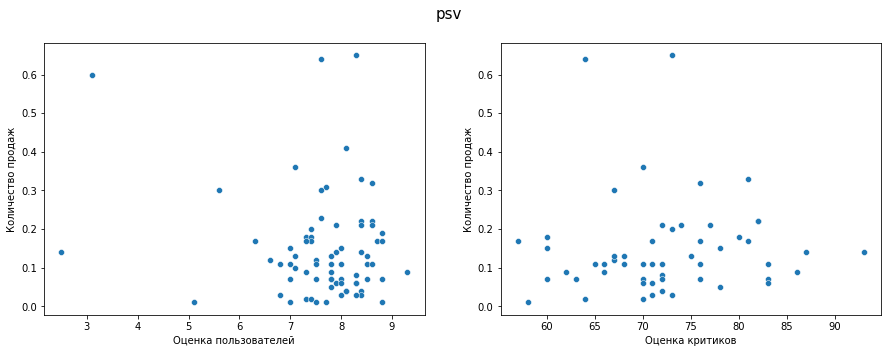

Корреляция между отзывами критиков и игровой платформой  psv 0.04266490657009526
Корреляция между отзывами пользователей и продажами  psv -0.16845504978064446


In [89]:
#Посчитаем и отрисуем корреляцию для платформы 'psv'
platform_user_psv = platform_user[platform_user['platform']=='psv']
platform_critic_psv = platform_critic[platform_critic['platform']=='psv']
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.scatterplot(x='user_score', y='sales', data=platform_user_psv, ax=ax[0])
sns.scatterplot(x='critic_score', y='sales', data=platform_critic_psv, ax=ax[1])
fig.suptitle('psv', fontsize=15)
ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Количество продаж')
ax[1].set(ylabel='Количество продаж')
plt.show()
    
correl_user = platform_user_psv['user_score'].corr(platform_user_psv['sales'])
critic_correl = platform_critic_psv['critic_score'].corr(platform_critic_psv['sales'])
    
print('Корреляция между отзывами критиков и игровой платформой ', 'psv', critic_correl)
   
print('Корреляция между отзывами пользователей и продажами ', 'psv', correl_user)

#Выводы:
Корреляции между оценками критиков/пользователей и продажами игр по платформам весьма слабые.  Можно выделить умеренную корреляцию между критиков и игровой платформой  XONE 0.43, PS4 0.40, x360 0.52, ps3 0.45.
А также отрицательную корреляцию между отзывами пользователей и продажами  PSV 0.17, XONE -0.07, PS4 -0.04, PS3 -0.17, x360 -0.14

# Распределение игр по жанрам

Посмотрим на распределение платформ по жанрам

In [92]:
#подготовим данные
df_genre_sum = current_period.pivot_table(index='genre', values='sales', aggfunc='sum').sort_values(by='sales', 
                                                                                                 ascending=False).reset_index()
df_genre_sum

,genre,sales
0,action,199.36
1,shooter,170.94
2,sports,109.48
3,role-playing,101.44
4,misc,37.55
5,fighting,28.22
6,racing,27.52
7,platform,18.09
8,adventure,17.55
9,simulation,13.13


In [93]:
df_genre_median = current_period.pivot_table(index='genre', values='sales', aggfunc='median').sort_values(by='sales', 
                                                                                                 ascending=False).reset_index()
df_genre_median

,genre,sales
0,shooter,0.515
1,sports,0.180
2,platform,0.140
3,fighting,0.125
4,role-playing,0.110
5,simulation,0.100
6,action,0.090
7,misc,0.090
8,racing,0.090
9,strategy,0.060


Text(0, 0.5, 'Продажи')

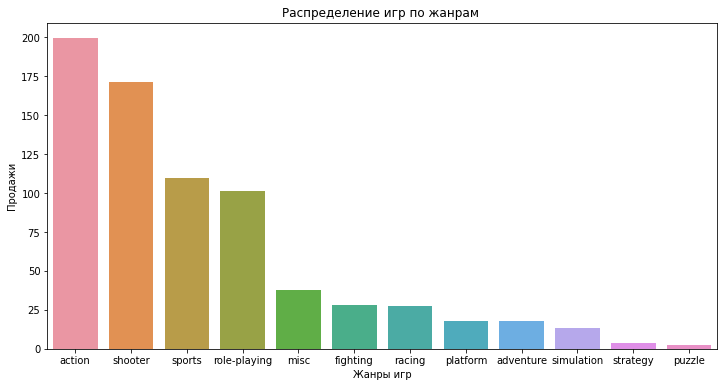

In [94]:
#построим распределение
plt.figure(figsize=(12,6))
plt.title('Распределение игр по жанрам ')
sns.barplot(data=df_genre_sum, x='genre', y='sales')
plt.xlabel('Жанры игр')
plt.ylabel('Продажи')

Text(0, 0.5, 'Продажи (медиана)')

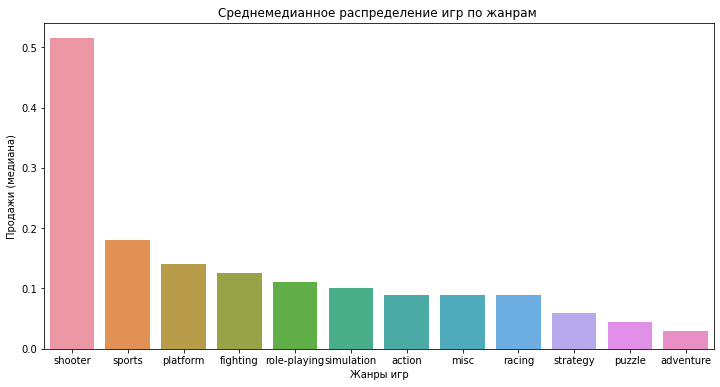

In [95]:
plt.figure(figsize=(12,6))
plt.title('Среднемедианное распределение игр по жанрам ')
sns.barplot(data=df_genre_median, x='genre', y='sales')
plt.xlabel('Жанры игр')
plt.ylabel('Продажи (медиана)')

(0.0, 2.0)

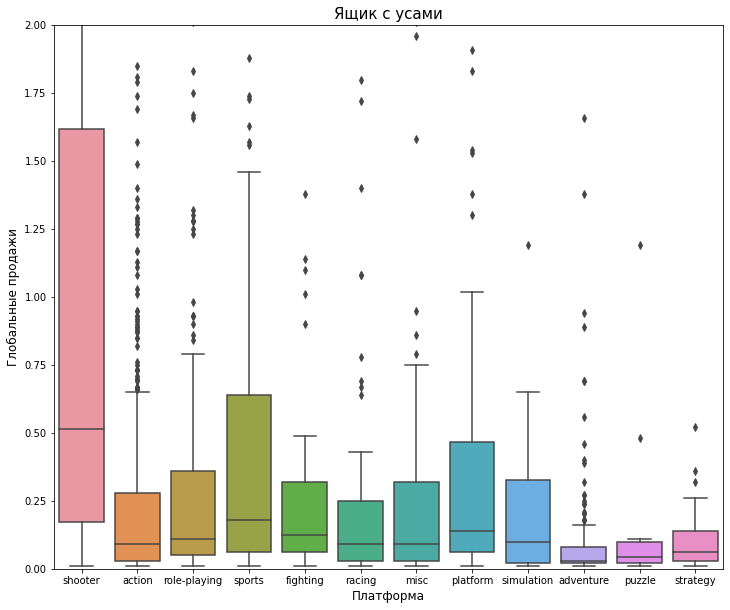

In [96]:
# построим диаграмму размаха
plt.figure(figsize=(12,10))
sns.boxplot(data=current_period, x='genre', y='sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи',fontsize=12)
plt.ylim(0, 2)

По количеству проданных игр лидирует жанр экшен, шутер, спорт и ролевые игры 
По среднемедианному значению в лидерах шутер, спорт и платформы, ролевые игры только на 5 месте, а экшен на 7 месте.
Поэтому в топе по продажам можно отметить только шутер, спорт и ролевые игры. В жанре экшен есть игры с большим количеством продаж.

Выводы:
1. Вплоть до 1990 года количество проданных игр мало. Думаю связанно это с малой компьютеризацией. В 90-х года происходит резкий рост количества компьютеров и развитие компьютерной техники, а также повышение вычислительной мощности машин. Пик продаж приходится на период 2001 - 2011 годы с пиком в 2008 и 2009 годах.
2. В 80-х больше всего продаж было у платформы nes. В 1989 году начинает выстреливать платформа gb. В 90-х больше всего продаж было у платформы ps. В 2000-х все более интересно. С появлением ps2 интерес к старой платформе ps сходит на нет уже в 2001 году. В 2006 году ps2 в продажах теснит платформа wii и xbox360. В 2010-х годах наблюдается спад продаж игр на платформах. И к 2014 году в лидеры выбивается новая платформа ps4.
3. В топе по реализации платформа ps2 за ней идет x360 и wii
4. Большинство платформ имеют приближенное к нормальному распределение по годам, за некоторым исключением платформы: gb, pc, snes, scd, tg16, 3do, gg, pcfx. Средний срок жизни платформ 7 лет До 2016 года добрались не многие: PS4, PC, Nintendo 3DS, XBOX One, Nintendo Wii U, PlayStation Vita.
5. Топ 3 платформы по продажам игр за период 20 -2016 годы: xbox, ps3, ps4. Персональные компьютеры отошли на второй план, уступив место приставкам. Корреляции между продажами игр на платформа и оценками критиков/пользователей для каждой платформы слабые.
6. Больше всего выпущенных игр в жанре шутер, спорт и ролевые игры



# Составьте портрет пользователя каждого региона

# Самые популярные платформы

In [97]:
#найдем топ платформ по регионам, для этого напишем функцию
def top_sales_by_region(current_period, platform, values_column, n=5):
    sales = current_period.pivot_table(index='platform', values=values_column, aggfunc='sum').sort_values(by=values_column, ascending=False).reset_index().head(n)
    return sales



In [98]:
top_sales_by_region(current_period, 'platform', 'na_sales')

,platform,na_sales
0,ps4,98.61
1,xone,81.27
2,x360,28.30
3,3ds,22.64
4,ps3,22.05


In [99]:
#отрисуем топ по регионам
def top_sales_by_region_gr(current_period, platform, values_column, n=5):
    sales = df.groupby('platform')[values_column].sum().sort_values(ascending=False).head(5).reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=sales, x='platform', y=values_column)
    plt.title('Топ 5 платформ в '+ values_column )
    plt.xlabel('Platform')
    plt.ylabel(values_column)
    plt.xticks(rotation=45)
    plt.show()

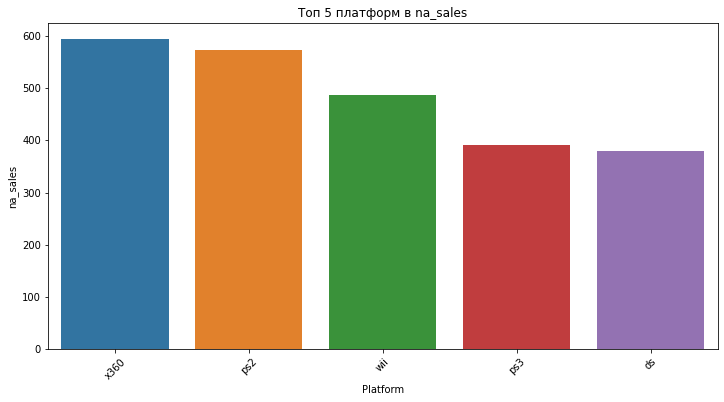

In [100]:
top_sales_by_region_gr(current_period, 'platform', 'na_sales')

В Сев. Америке в топе игры на платформах x360, ps2, wii

In [101]:
top_sales_by_region(current_period, 'platform', 'eu_sales')

,platform,eu_sales
0,ps4,130.04
1,xone,46.25
2,ps3,25.54
3,pc,17.97
4,3ds,16.12


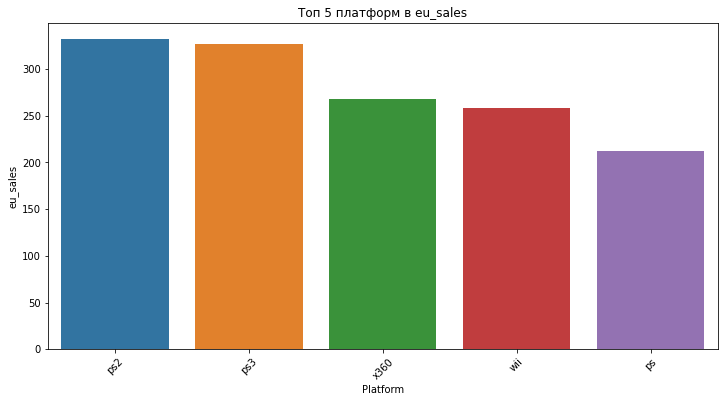

In [102]:
top_sales_by_region_gr(current_period, 'platform', 'eu_sales')

Европейский топ: ps2, ps3, x360 

In [103]:
top_sales_by_region(current_period, 'platform', 'jp_sales')

,platform,jp_sales
0,3ds,44.24
1,ps4,15.02
2,psv,14.54
3,ps3,11.22
4,wiiu,7.31


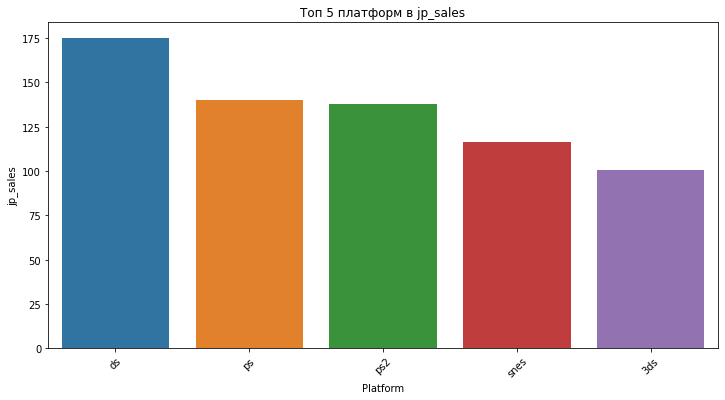

In [104]:
top_sales_by_region_gr(current_period, 'platform', 'jp_sales')

Япойнский топ: ds, ps, ps2

Выводы:
    Предпочтения пользователей в разных регионах мира весьма разные. В Америке лябят игры на платформах x360, ps2, wii; в европе - ps2, ps3, x360; в Японии - ds, ps, ps2.

# Самые популярные жанры

In [105]:
#Напишем функции для всего этого безобразия))
def top_sales_by_genre(current_period, genre, values_column, n=5):
    sales = current_period.pivot_table(index='genre', values=values_column, aggfunc='sum').sort_values(by=values_column, ascending=False).reset_index().head(n)
    return sales
def top_sales_by_genre_gr(current_period, genre, values_column, n=5):
    sales = current_period.groupby('genre')[values_column].sum().sort_values(ascending=False).head(n).reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=sales, x='genre', y=values_column)
    plt.title('Топ 5 жанров в '+ values_column )
    plt.xlabel('Genre')
    plt.ylabel(values_column)
    plt.xticks(rotation=45)
    plt.show()

In [106]:
top_sales_by_genre(current_period, 'genre', 'na_sales')

,genre,na_sales
0,shooter,79.02
1,action,72.53
2,sports,46.13
3,role-playing,33.47
4,misc,15.05


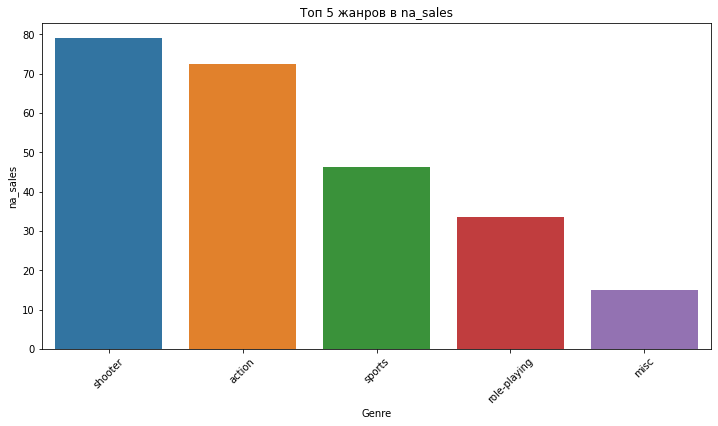

In [107]:
top_sales_by_genre_gr(current_period, 'genre', 'na_sales')

В Сев. Америке топом по жанрам являются: экшн, спорт и шуттер

In [108]:
top_sales_by_genre(current_period, 'genre', 'eu_sales')

,genre,eu_sales
0,action,74.68
1,shooter,65.52
2,sports,45.73
3,role-playing,28.17
4,racing,14.13


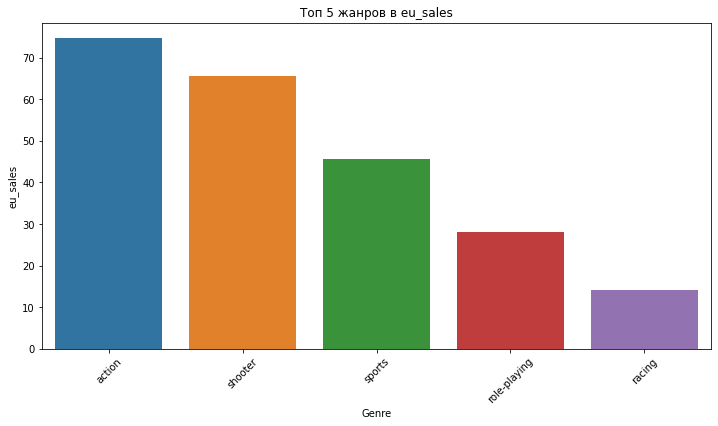

In [109]:
top_sales_by_genre_gr(current_period, 'genre', 'eu_sales')

В европе в топе жанры: экшн, спорт и шуттер

In [110]:
top_sales_by_genre(current_period, 'genre', 'jp_sales')

,genre,jp_sales
0,role-playing,31.16
1,action,29.58
2,fighting,6.37
3,misc,5.61
4,shooter,4.87


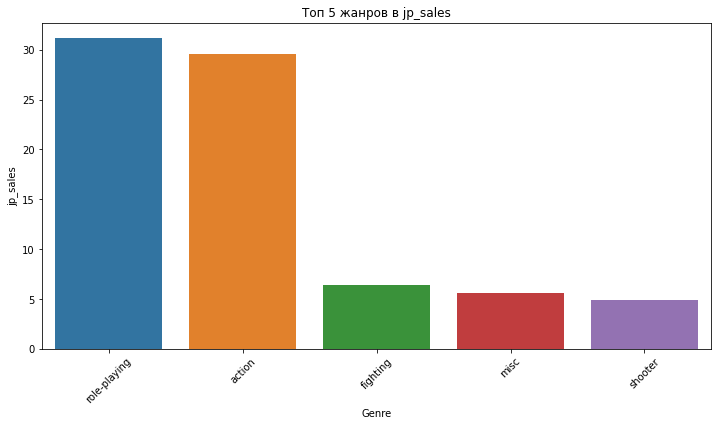

In [111]:
top_sales_by_genre_gr(current_period, 'genre', 'jp_sales')

В Японии - ролевые игры, экшн, спорт

В большинстве стран предпочитают экшен и спорт

# Рейтинг ESRB

In [112]:
def top_sales_by_ESRB(current_period, rating, values_column, n=5):
    sales = current_period.pivot_table(index='rating', values=values_column, aggfunc='sum').sort_values(by=values_column, ascending=False).reset_index().head(n)
    return sales
def top_sales_by_ESRB_gr(current_period, rating, values_column, n=5):
    sales = current_period.groupby('rating')[values_column].sum().sort_values(ascending=False).head(5).reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=sales, x='rating', y=values_column)
    plt.title('Топ 5 рейтинга ESRB в '+ values_column )
    plt.xlabel('Platform')
    plt.ylabel('Продажи в ' + values_column)
    plt.xticks(rotation=45)
    plt.show()

In [113]:
top_sales_by_ESRB(current_period, 'rating', 'na_sales')

,rating,na_sales
0,M,96.42
1,O_o,64.72
2,E,50.74
3,T,38.95
4,E10+,33.23


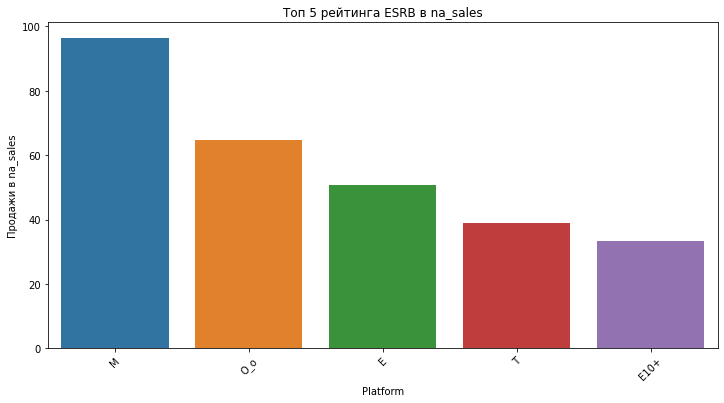

In [114]:
top_sales_by_ESRB_gr(current_period, 'rating', 'na_sales')

По рейтингу ESRB в Сев. Америке в топе игры без рейтинга, для подростков и для взрослых

In [115]:
top_sales_by_ESRB(current_period, 'rating', 'eu_sales')

,rating,eu_sales
0,M,93.44
1,O_o,58.95
2,E,58.06
3,T,34.07
4,E10+,26.16


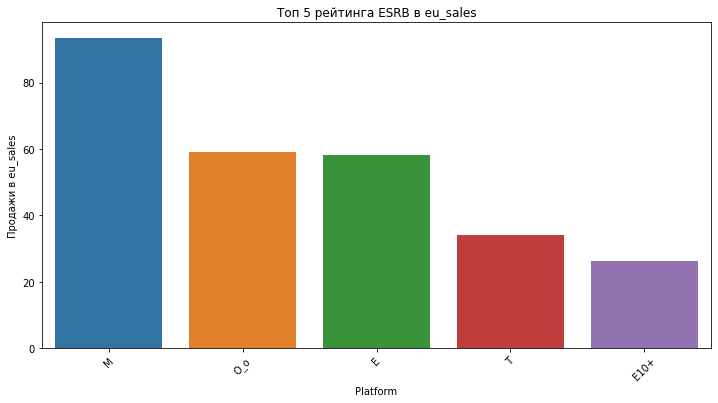

In [116]:
top_sales_by_ESRB_gr(current_period, 'rating', 'eu_sales')

По рейтингу ESRB в Европы в топе игры без рейтинга, для взрослых и для подростков

In [117]:
top_sales_by_ESRB(current_period, 'rating', 'jp_sales')

,rating,jp_sales
0,O_o,56.90
1,T,14.78
2,E,8.94
3,M,8.01
4,E10+,4.46


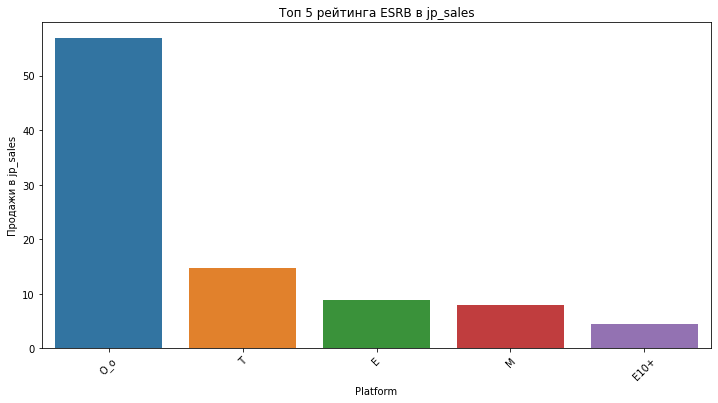

In [118]:
top_sales_by_ESRB_gr(current_period, 'rating', 'jp_sales')

По рейтингу ESRB в Японии в топе игры без рейтинга, для всех, для подростков и для взрослых

Вывод:
1. В Сев. Америке в топе игры на платформах x360, ps2, wii. Европейский топ: ps2, ps3, x360. Япойнский топ: ds, ps, ps2.
2. В Сев. Америке и Европе топом по жанрам являются: экшн, спорт и шуттер. В Японии - ролевые игры, экшн, спорт.
3. По рейтингу ESRB в Сев. Америке в топе игры без рейтинга, для подростков и для взрослых. 
    По рейтингу ESRB в Европы в топе игры без рейтинга, для взрослых и для подростков. По рейтингу ESRB в Японии в топе игры без рейтинга (не удивительно, ведь он только для игр, продаваемых в США и Канаде), для всех, для подростков и для взрослых


# Проверка гипотиз

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Задайте самостоятельно пороговое значение alpha.

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Альтернативная - Средние пользовательские рейтинги платформ Xbox One и PC разные

In [120]:
#отфильтруем датасет
current_period = current_period[current_period['user_score'] > 0]

In [121]:
#Подготовим данные
# Сохраним в переменных xbox_hyp и pc_hyp соответствующие данные (актуальные данные за последние 10 лет)
xone= current_period[(current_period['platform']=='xone')]['user_score']
pc= current_period[(current_period['platform']=='pc')]['user_score']

#Посчитаем средний рейтинг пользователя для xbox платформs
print('средний рейтинг пользователя для xbox платформы', xone.mean())

средний рейтинг пользователя для xbox платформы 6.594545454545456


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


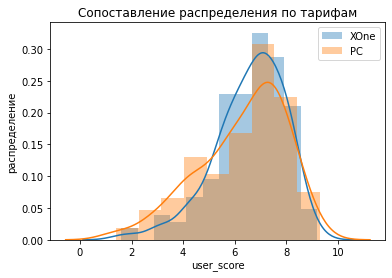

In [122]:
#построим распределение по каждой из выборок
fig = plt.figure()
plt.xlabel('xlabel')
plt.ylabel('распределение')
plt.title('Сопоставление распределения по тарифам')
sns.distplot(xone, label='XOne')
sns.distplot(pc, label='PC')
plt.legend()
plt.show()

Вид распеределения вцелом нормальный, хоть и емного смещенный.

In [123]:
#Посчитаем средний рейтинг пользователя для PC платформ
print('средний рейтинг пользователя для PC платформы', pc.mean())

средний рейтинг пользователя для PC платформы 6.298360655737705


In [124]:
# Произведем проверку дисперсии выборок
np.var(current_period[current_period['platform']=='xone']['user_score'])

1.8795460055096425

In [125]:
np.var(current_period[current_period['platform']=='pc']['user_score'])

2.8773743617307175

Отмечу,что выборки не зависимы

In [126]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = .05

results = st.ttest_ind(xone.dropna(), pc.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


# Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [127]:
#Подготовим данные
# Сохраним в переменных Action и Sports соответствующие данные (актуальные данные за последние 10 лет)
action = current_period[(current_period['genre']=='action') & (current_period['user_score'] > 0)]['user_score']
sports = current_period[(current_period['genre']=='sports') & (current_period['user_score'] > 0)]['user_score']

#Посчитаем средний рейтинг пользователя для жанра экшен
print('средний рейтинг пользователя для жанра экшен', action.mean())

средний рейтинг пользователя для жанра экшен 6.760606060606061


In [128]:
#Посчитаем средний рейтинг пользователя для жанра ыпорт
print('средний рейтинг пользователя для жанра спорт', sports.mean())

средний рейтинг пользователя для жанра спорт 5.2251968503937


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


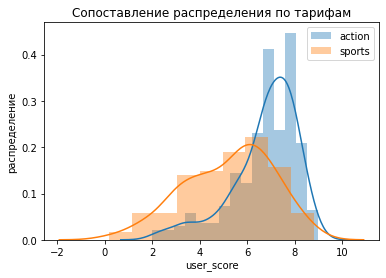

In [129]:
#построим распределение по каждой из выборок
fig = plt.figure()
plt.xlabel('xlabel')
plt.ylabel('распределение')
plt.title('Сопоставление распределения по тарифам')
sns.distplot(action, label='action')
sns.distplot(sports, label='sports')
plt.legend()
plt.show()

Вид распеределения вцелом нормальный, хоть и емного смещенный.

In [130]:
# Произведем проверку дисперсии выборок
np.var(current_period[current_period['genre']=='action']['user_score'])

1.89208448117539

In [131]:
# Произведем проверку дисперсии выборок
np.var(current_period[current_period['genre']=='sports']['user_score'])

3.4198375596751185

Отмечу,что выборки не зависимы

In [132]:
#Выполним проверку гипотезы. Будем использовать метод ttest_ind

alpha = .05

results = st.ttest_ind(action.dropna(), sports.dropna(), equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Построение гипотез делалось из принципа: нулевая гипотеза всегда про равенство, альтернативная гипотеза про неравенство или больше или меньше,  исходя из этого надо сформулированы гипотезы.
Использовал стандартный критерий равный 0,05

Выводы:
1. Гипотеза: "Средние пользовательские рейтинги платформ Xbox one и PC одинаковые". Нулевую гипотезу не удалось опровергнуть. таким образом Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
1. Гипотеза: "Средние пользовательские рейтинги жанров Action и Sports разные". Отвергаем нулевую гипотезу. Таким образом средние пользовательские рейтинги жанров Action и Sports различаются.

# Общие выводы

Данные для исследования достаточно чистые, проблемных мест не много. Многие проблемные места были заменены заглушками или удалены.

1. Вплоть до 1990 года количество проданных игр мало. Думаю связанно это с малой компьютеризацией. В 90-х года происходит резкий рост количества компьютеров и развитие компьютерной техники, а также повышение вычислительной мощности машин. Пик продаж приходится на период 2001 - 2011 годы с пиком в 2008 и 2009 годах.
2. В 80-х больше всего продаж было у платформы nes. В 1989 году начинает выстреливать платформа gb. В 90-х больше всего продаж было у платформы ps. В 2000-х все более интересно. С появлением ps2 интерес к старой платформе ps сходит на нет уже в 2001 году. В 2006 году ps2 в продажах теснит платформа wii и xbox360. В 2010-х годах наблюдается спад продаж игр на платформах. И к 2014 году в лидеры выбивается новая платформа ps4.
3. В топе по реализации платформа ps2 за ней идет x360 и wii
4. Большинство платформ имеют приближенное к нормальному распределение по годам, за некоторым исключением платформы: gb, pc, snes, scd, tg16, 3do, gg, pcfx. Средний срок жизни платформ 5-10 лет До 2016 года добрались не многие: PS4, PC, Nintendo 3DS, XBOX One, Nintendo Wii U, PlayStation Vita.
5. Топ 3 платформы по продажам игр за период 2014 -2016 годы:  ps4, xone, wiiu. Персональные компьютеры отошли на второй план, уступив место приставкам. Корреляции между продажами игр на платформа и оценками критиков/пользователей для каждой платформы слабые. Можно выделить умеренную корреляцию между критиков и игровой платформой XONE 0.43, PS4 0.40, x360 0.52, ps3 0.45. А также отрицательную корреляцию между отзывами пользователей и продажами PSV 0.17, XONE -0.07, PS4 -0.04, PS3 -0.17, x360 -0.14
6. По количеству проданных игр лидирует жанр экшен, шутер, спорт и ролевые игры По среднемедианному значению в лидерах шутер, спорт и платформы, ролевые игры только на 5 месте, а экшен на 7 месте. Поэтому в топе по продажам можно отметить только шутер, спорт и ролевые игры. В жанре экшен есть игры с большим количеством продаж.
7. Портрет пользователе разных регионов

В Северной америке:
- Топ платформ :x360, ps2, wii
- топ по жанрам: экшн, спорт и шуттер.
- Топ рейтинга ESRB: игры без рейтинга, для подростков и для взрослых

В Европе:
- Топ платформ: ps2, ps3, x360.
- топ  по жанрам: экшн, спорт и шуттер.
- топ рейтинга ESRB: игры без рейтинга, для взрослых и для подростков

В Японии:
- Топ платформ: ds, ps, ps2.
- топ  по жанрам: ролевые игры, экшн, спорт.
- топ рейтинга ESRB: в игры без рейтинга (не удивительно, ведь он только для игр, продаваемых в США и Канаде), для всех, для подростков и для взрослых.

Но, т.к. в общем объеме продаж игры в стиле экшн имеют малую силу, то их рассматривать как точку роста нельзя

9. Гипотеза: "Средние пользовательские рейтинги платформ Xbox one и PC одинаковые". Нулевую гипотезу не удалось опровергнуть. таким образом Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
Гипотеза: "Средние пользовательские рейтинги жанров Action и Sports разные". Отвергаем нулевую гипотезу. Таким образом средние пользовательские рейтинги жанров Action и Sports различаются.
    
    Из общих рекомендаций, можно сказать что на плаву осталось мало платформ. На 2017 актуальными платформами являются PS4 и xone, игры на этих платформах стоит продавать больше. Акцент в рекламе делать на игры в жанрах спорт и экшен, т.к. эти жанры популярны на многих континентах.